In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from scipy import stats
from statistics import stdev
import datetime
from datetime import timedelta
from collections import Counter
import cx_Oracle
import psycopg2
import seaborn as sns
import json
import pickle
#from fitter import Fitter
from warnings import filterwarnings
from itertools import compress
filterwarnings('ignore')

ES shop: for every customer having placed his 1st order between 01/07/15 and 30/06/17, get all their orders until 30/06/18

### Data loading, cleaning & formatting

In [2]:
data = pd.read_csv('es_shop_orders_sp_cross_selling_v2.dsv', sep=';', low_memory=False)

In [3]:
data.sample(5)

,SCM_N_ORDER_POS_NR,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,THR_C_KEY_ORDER_HOUR,SIT_N_KEY_SITE,CUS_N_KEY_CUSTOMER,SCM_SALES_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,SCM_D_ORIG_FINANCE_ORDER_NET,...,OSP_KO_COUNT_NET,OSP_3_LEAD_P_PG_ID,OSP_3_LEAD_P_PG_SHARE,OSP_4_LEAD_P_PG_ID,OSP_4_LEAD_P_PG_SHARE,CZP_START_DATE,CZP_EXPIRY_DATE,CZP_ZTQ_ID,CZP_PERCENTAGE,CZP_PRICE
3563834,328018680,77259215,08/11/2016 00:00,18:32,15,14844264,"9,99","3,4418","0,9721","9,0818",...,3,301,"0,5103",10331,"0,5103",NaN,NaN,NaN,NaN,NaN
2803741,380392850,89138715,17/06/2017 00:00,18:15,15,13514282,"2,49","0,8136","0,5938","2,2636",...,7,252,"0,4636",683,"0,2889",NaN,NaN,NaN,NaN,NaN
1302983,474916141,111591157,29/05/2018 00:00,00:11,15,13430514,"3,7388","1,1142","0,3897","3,3989",...,17,252,"0,2283",10331,"0,1827",29/05/2018 00:00,29/05/2021 00:00,52.0,3.0,"5,99"
1278275,450766072,105704017,01/03/2018 00:00,17:14,15,15557934,"4,5082","1,2839","0,1673","4,0984",...,6,252,"0,4486",3641,"0,4299",01/03/2018 17:14,16/03/2018 12:01,51.0,3.0,"2,99"
2297980,290918124,68728723,15/05/2016 00:00,21:00,15,12221039,"14,99","7,9273","4,3109","13,6273",...,14,252,"0,7502",140759,"0,7502",NaN,NaN,NaN,NaN,NaN


In [4]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4074789 entries, 0 to 4074788
Data columns (total 23 columns):
SCM_N_ORDER_POS_NR              int64
SCM_N_ORDER_NR                  int64
TDT_T_KEY_ORDER_DATE            object
THR_C_KEY_ORDER_HOUR            object
SIT_N_KEY_SITE                  int64
CUS_N_KEY_CUSTOMER              int64
SCM_SALES_BMF                   object
SCM_D_FINANCE_CM1               object
SCM_D_FINANCE_CM2               object
SCM_D_ORIG_FINANCE_ORDER_NET    object
SCM_AP_ID                       int64
SCM_AS_ID                       int64
SCM_MASTER_AP_ID                int64
OSP_KO_COUNT_NET                int64
OSP_3_LEAD_P_PG_ID              int64
OSP_3_LEAD_P_PG_SHARE           object
OSP_4_LEAD_P_PG_ID              int64
OSP_4_LEAD_P_PG_SHARE           object
CZP_START_DATE                  object
CZP_EXPIRY_DATE                 object
CZP_ZTQ_ID                      float64
CZP_PERCENTAGE                  float64
CZP_PRICE                       objec

In [5]:
def get_date(x):
    return x.split(' ')[0]

In [6]:
data['TDT_T_KEY_ORDER_DATE'] = data['TDT_T_KEY_ORDER_DATE'].map(get_date)

In [7]:
data['TDT_T_KEY_ORDER_DATE'] = pd.to_datetime(data['TDT_T_KEY_ORDER_DATE'], format='%d/%m/%Y')

In [8]:
data['ORDER_DATETIME'] = data['TDT_T_KEY_ORDER_DATE'].astype(str) + ' ' + data['THR_C_KEY_ORDER_HOUR'].astype(str) + ':00'

In [9]:
data['ORDER_DATETIME'] = pd.to_datetime(data['ORDER_DATETIME'], format="%Y-%m-%d %H:%M:%S")

In [10]:
data['CZP_START_DATE'] = pd.to_datetime(data['CZP_START_DATE'], format="%d/%m/%Y %H:%M")
data['CZP_EXPIRY_DATE'] = pd.to_datetime(data['CZP_EXPIRY_DATE'], format="%d/%m/%Y %H:%M")

In [11]:
data['SCM_SALES_BMF'] = [float(str(i).replace(',','.')) for i in data['SCM_SALES_BMF'].values]
data['SCM_D_FINANCE_CM1'] = [float(str(i).replace(',','.')) for i in data['SCM_D_FINANCE_CM1'].values]
data['SCM_D_FINANCE_CM2'] = [float(str(i).replace(',','.')) for i in data['SCM_D_FINANCE_CM2'].values]
data['SCM_D_ORIG_FINANCE_ORDER_NET'] = [float(str(i).replace(',','.')) for i in data['SCM_D_ORIG_FINANCE_ORDER_NET'].values]

In [12]:
data['CZP_PRICE'] = [float(str(i).replace(',','.')) for i in data['CZP_PRICE'].values]
data['OSP_3_LEAD_P_PG_SHARE'] = [float(str(i).replace(',','.')) for i in data['OSP_3_LEAD_P_PG_SHARE'].values]
data['OSP_4_LEAD_P_PG_SHARE'] = [float(str(i).replace(',','.')) for i in data['OSP_4_LEAD_P_PG_SHARE'].values]

In [13]:
#boolean mask with duplicated orders due to SP as True
dupl_mask = [len(i) > 1 for i in data.groupby('SCM_N_ORDER_NR')['CZP_START_DATE'].unique().values]

In [14]:
#get duplicated order IDs
dup_orders = data.groupby('SCM_N_ORDER_NR')['CZP_START_DATE'].unique()[dupl_mask].index.values

In [15]:
len(dup_orders)

2855

In [16]:
sp_acq_dup_orders = list(data[data['SCM_N_ORDER_NR'].isin(dup_orders)][data[data['SCM_N_ORDER_NR'].isin(dup_orders)]['SCM_MASTER_AP_ID'] == 42225]['SCM_N_ORDER_NR'].unique())
len(sp_acq_dup_orders)

2845

In [17]:
no_sp_acq_dup_orders = [i for i in dup_orders if i not in sp_acq_dup_orders]
len(no_sp_acq_dup_orders)

10

In [18]:
#Let's get incorrect duplicated indexes instead of order_id to exclude them and select the correct data subset
dup_indexes = []

for i in sp_acq_dup_orders:
    o_id = data[data['SCM_N_ORDER_NR'] == i]
    old_sp_date = min(o_id['CZP_START_DATE'])
    old_sp_index = o_id[o_id['CZP_START_DATE'] == old_sp_date].index.values
    dup_indexes.append(old_sp_index)

In [19]:
len(dup_indexes)

2845

In [20]:
for i in no_sp_acq_dup_orders:
    c_id = data[data['SCM_N_ORDER_NR'] == i]['CUS_N_KEY_CUSTOMER'].unique()[0]
    cust_orders = data[data['CUS_N_KEY_CUSTOMER'] == c_id]
    sp_order = cust_orders[cust_orders['SCM_MASTER_AP_ID'] == 42225]['SCM_N_ORDER_NR'].unique()[0]
    if i < sp_order:
        o_id = data[data['SCM_N_ORDER_NR'] == i]
        new_non_valid_sp_date = max(o_id['CZP_START_DATE'])
        new_sp_index = o_id[o_id['CZP_START_DATE'] == new_non_valid_sp_date].index.values
        dup_indexes.append(new_sp_index)
    else:
        o_id = data[data['SCM_N_ORDER_NR'] == i]
        old_sp_date = min(o_id['CZP_START_DATE'])
        old_sp_index = o_id[o_id['CZP_START_DATE'] == old_sp_date].index.values
        dup_indexes.append(old_sp_index)

In [21]:
len(dup_indexes)

2855

In [22]:
#Get a flatten list of indexes
dupl_ind = [i for lista in dup_indexes for i in lista]

print('Duplicated rows detected: ', len(dupl_ind))
print('Start dropping..')

#Drop duplicated indexes
data.drop(dupl_ind, inplace=True)

#0 printed, in order to be sure there are no orders duplicated remaining...
print('Number of order IDs having more than one SP_START_DATE now: ',
      sum(len(i) > 1 for i in data.groupby('SCM_N_ORDER_NR')['CZP_START_DATE'].unique().values))

Duplicated rows detected:  19526
Start dropping..
Number of order IDs having more than one SP_START_DATE now:  0


In [23]:
data['FIRST_O_DATE'] = data['TDT_T_KEY_ORDER_DATE'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('min')

In [24]:
data['LAST_O_DATE'] = data['TDT_T_KEY_ORDER_DATE'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('max')

In [25]:
data['1ST_O_COUNTER'] = data['OSP_KO_COUNT_NET'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('min')

In [26]:
data['MAX_SALES_O_POS'] = data['SCM_SALES_BMF'].groupby(data['SCM_N_ORDER_NR']).transform('max')
data['IS_LEAD_AS'] = (data['SCM_SALES_BMF'] == data['MAX_SALES_O_POS']) * 1 * data['SCM_AS_ID']
data['LEAD_AS_ID'] = data['IS_LEAD_AS'].groupby(data['SCM_N_ORDER_NR']).transform('max')

In [27]:
data['D28'] = data['FIRST_O_DATE'] + timedelta(days = 28)
data['D56'] = data['FIRST_O_DATE'] + timedelta(days = 56)
data['D84'] = data['FIRST_O_DATE'] + timedelta(days = 84)
data['D252'] = data['FIRST_O_DATE'] + timedelta(days = 252)
data['D252'] = data['FIRST_O_DATE'] + timedelta(days = 252)
data['D336'] = data['FIRST_O_DATE'] + timedelta(days = 336)

In [28]:
#Get brands per PG4
brands = pd.read_csv('pg4_brands.dsv', sep=';', low_memory=False)

In [29]:
brands['BRAND'] = [i.split(' - ')[1] if len(i.split('-')) > 1 else 'unknown' for i in brands['PPR_V_LEVEL4_DESC'].values]

In [30]:
brands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2006 entries, 0 to 2005
Data columns (total 3 columns):
PPR_N_LEVEL4_ID      2006 non-null int64
PPR_V_LEVEL4_DESC    2006 non-null object
BRAND                2006 non-null object
dtypes: int64(1), object(2)
memory usage: 47.1+ KB


In [31]:
brands.sample(10)

,PPR_N_LEVEL4_ID,PPR_V_LEVEL4_DESC,BRAND
466,279533,279533 - Superbox Dog XMas 2017,Superbox Dog XMas 2017
854,921,921 - Chinchillakäfig,Chinchillakäfig
603,3082,3082 - Tommy 82 C3,Tommy 82 C3
1840,180,180 - Goldfischfutter,Goldfischfutter
1983,250511,250511 - Smolke,Smolke
202,183141,183141 - Lamm,Lamm
771,315097,315097 - Biofood,Biofood
1025,2196,2196 - Sparpakete,Sparpakete
257,17798,17798 - Royal Canin Breed (Rasse),Royal Canin Breed (Rasse)
1110,525,525 - Durchlüfter/-ersatzteile,Durchlüfter/-ersatzteile


In [32]:
#Get physical articles with their PG structure
ap_pg = pd.read_csv('vw_ap_pg_link.dsv', sep=';', low_memory=False)

In [33]:
ap_pg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62994 entries, 0 to 62993
Data columns (total 9 columns):
AP_ID       62994 non-null int64
PP_ID       62994 non-null int64
L1_PG_ID    62994 non-null int64
L2_PG_ID    62993 non-null float64
L3_PG_ID    62537 non-null float64
L4_PG_ID    60229 non-null float64
L5_PG_ID    29125 non-null float64
L6_PG_ID    18 non-null float64
L7_PG_ID    0 non-null float64
dtypes: float64(6), int64(3)
memory usage: 4.3 MB


In [34]:
ap_pg = ap_pg[['AP_ID', 'L3_PG_ID', 'L4_PG_ID']].fillna(0).astype(int)

In [35]:
ap_pg.sample(10)

,AP_ID,L3_PG_ID,L4_PG_ID
36465,50727,45,153
20986,68771,857,2128
31349,81581,34,72116
34627,24067,15816,15817
3210,25255,45,151
22496,68165,251,81396
46076,62883,2190,15017
54578,60396,251,255
60660,57514,13505,13506
15719,71361,2068,118139


In [36]:
#Merge both tables to add the brand for each AP_ID
ap_pg_brand = pd.merge(ap_pg, brands, how='left', left_on='L4_PG_ID', right_on='PPR_N_LEVEL4_ID')

In [37]:
ap_pg_brand.sample(20)

,AP_ID,L3_PG_ID,L4_PG_ID,PPR_N_LEVEL4_ID,PPR_V_LEVEL4_DESC,BRAND
30025,82048,40023,43280,43280,43280 - Hundeschuhe,Hundeschuhe
7251,55287,409,60757,60757,60757 - FURminator,FURminator
54231,78831,2068,10728,10728,10728 - Whiskas,Whiskas
46989,81174,2068,2632,2632,2632 - ★ Cosma,★ Cosma
9092,9133,965,975,975,975 - Schlauch-/Rohrzubehör,Schlauch-/Rohrzubehör
44827,60510,857,129147,129147,129147 - Belcando,Belcando
46114,78253,2068,2079,2079,2079 - Miamor,Miamor
55152,44561,2068,3155,3155,3155 - Schesir,Schesir
25721,15570,251,682,682,682 - Royal Canin Size,Royal Canin Size
46491,62267,2155,2157,2157,2157 - Alle Katzenklappen,Alle Katzenklappen


In [38]:
data = pd.merge(data, ap_pg_brand, how='left', left_on='SCM_AP_ID', right_on='AP_ID')

In [39]:
data[['AP_ID', 'L3_PG_ID', 'L4_PG_ID', 'PPR_N_LEVEL4_ID']] = data[['AP_ID', 'L3_PG_ID', 'L4_PG_ID', 'PPR_N_LEVEL4_ID']].fillna(0).astype(int)

In [40]:
data.sample(10)

,SCM_N_ORDER_POS_NR,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,THR_C_KEY_ORDER_HOUR,SIT_N_KEY_SITE,CUS_N_KEY_CUSTOMER,SCM_SALES_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,SCM_D_ORIG_FINANCE_ORDER_NET,...,D56,D84,D252,D336,AP_ID,L3_PG_ID,L4_PG_ID,PPR_N_LEVEL4_ID,PPR_V_LEVEL4_DESC,BRAND
2980842,460600157,108003401,2018-04-04,03:28,15,16867594,3.99,1.1373,0.5116,3.6273,...,2017-07-12,2017-08-09,2018-01-24,2018-04-18,63188,2068,2127,2127,2127 - Almo Nature,Almo Nature
2124066,373005171,87447887,2017-05-17,13:08,15,12275981,4.99,1.9740,1.5107,4.1240,...,2015-10-22,2015-11-19,2016-05-05,2016-07-28,27908,20,96500,96500,96500 - Kuschelspielzeug,Kuschelspielzeug
122168,282674075,66790457,2016-04-03,01:03,15,13588592,-5.82,-4.7317,-4.7317,-4.7317,...,2016-04-19,2016-05-17,2016-11-01,2017-01-24,0,0,0,0,NaN,NaN
2526755,328209932,77303926,2016-11-09,15:12,15,14029568,46.99,0.4582,-4.5418,42.7182,...,2016-06-16,2016-07-14,2016-12-29,2017-03-23,69085,207553,207615,207615,207615 - Halsband,Halsband
901713,429795951,100720668,2017-12-16,10:39,15,14003231,17.99,5.5678,-2.2502,14.8678,...,2016-06-13,2016-07-11,2016-12-26,2017-03-20,34321,301,39682,39682,39682 - Sanicat,Sanicat
3042096,468252441,109925655,2018-05-03,08:36,15,14987903,32.99,13.5509,6.7678,29.9909,...,2016-10-26,2016-11-23,2017-05-10,2017-08-02,63208,252,2056,2056,2056 - Sanabelle,Sanabelle
3158588,344424588,80951314,2017-01-16,23:36,15,15978926,8.99,3.6127,2.4765,8.1727,...,2017-03-13,2017-04-10,2017-09-25,2017-12-18,50861,18,101,101,101 - Kauknochen & Kaurollen,Kauknochen & Kaurollen
2435652,267440031,63275378,2016-01-16,21:21,15,13270517,6.59,1.5209,0.0076,5.9909,...,2016-03-10,2016-04-07,2016-09-22,2016-12-15,37549,18,104,104,104 - vom Rind,vom Rind
1135858,474881279,111582955,2018-05-28,22:00,15,15456770,10.99,5.6309,4.4469,9.9909,...,2017-01-01,2017-01-29,2017-07-16,2017-10-08,74933,2068,9498,9498,9498 - Sheba,Sheba
2277902,341336966,80241174,2017-01-04,09:46,15,14132453,42.99,7.7118,-0.6580,39.0818,...,2016-06-29,2016-07-27,2017-01-11,2017-04-05,61093,251,682,682,682 - Royal Canin Size,Royal Canin Size


In [41]:
data.loc[2359877]

SCM_N_ORDER_POS_NR                              432883869
SCM_N_ORDER_NR                                  101465763
TDT_T_KEY_ORDER_DATE                  2017-12-29 00:00:00
THR_C_KEY_ORDER_HOUR                                21:51
SIT_N_KEY_SITE                                         15
CUS_N_KEY_CUSTOMER                               16405844
SCM_SALES_BMF                                      5.4282
SCM_D_FINANCE_CM1                                  1.5764
SCM_D_FINANCE_CM2                                  0.3982
SCM_D_ORIG_FINANCE_ORDER_NET                       4.9348
SCM_AP_ID                                           68397
SCM_AS_ID                                         2301001
SCM_MASTER_AP_ID                                    68325
OSP_KO_COUNT_NET                                        1
OSP_3_LEAD_P_PG_ID                                    251
OSP_3_LEAD_P_PG_SHARE                               0.778
OSP_4_LEAD_P_PG_ID                                  35825
OSP_4_LEAD_P_P

In [42]:
data.columns

Index(['SCM_N_ORDER_POS_NR', 'SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE',
       'THR_C_KEY_ORDER_HOUR', 'SIT_N_KEY_SITE', 'CUS_N_KEY_CUSTOMER',
       'SCM_SALES_BMF', 'SCM_D_FINANCE_CM1', 'SCM_D_FINANCE_CM2',
       'SCM_D_ORIG_FINANCE_ORDER_NET', 'SCM_AP_ID', 'SCM_AS_ID',
       'SCM_MASTER_AP_ID', 'OSP_KO_COUNT_NET', 'OSP_3_LEAD_P_PG_ID',
       'OSP_3_LEAD_P_PG_SHARE', 'OSP_4_LEAD_P_PG_ID', 'OSP_4_LEAD_P_PG_SHARE',
       'CZP_START_DATE', 'CZP_EXPIRY_DATE', 'CZP_ZTQ_ID', 'CZP_PERCENTAGE',
       'CZP_PRICE', 'ORDER_DATETIME', 'FIRST_O_DATE', 'LAST_O_DATE',
       '1ST_O_COUNTER', 'MAX_SALES_O_POS', 'IS_LEAD_AS', 'LEAD_AS_ID', 'D28',
       'D56', 'D84', 'D252', 'D336', 'AP_ID', 'L3_PG_ID', 'L4_PG_ID',
       'PPR_N_LEVEL4_ID', 'PPR_V_LEVEL4_DESC', 'BRAND'],
      dtype='object')

In [43]:
#data.to_pickle("./orders_es_shop_sp_cross_selling_v2.pkl")

### Order level

In [2]:
#data = pd.read_pickle("./orders_es_shop_sp_cross_selling_v2.pkl")

In [44]:
agg_ops = {'TDT_T_KEY_ORDER_DATE': min,
          'CUS_N_KEY_CUSTOMER': min,
          'SCM_SALES_BMF': [sum, lambda x: list(np.round(x, 2))],
          'SCM_D_FINANCE_CM1': sum,
          'SCM_D_FINANCE_CM2': sum,
          'SCM_D_ORIG_FINANCE_ORDER_NET': sum,
          'OSP_KO_COUNT_NET': min,
          'SCM_AP_ID': lambda x: list(x),
          'L4_PG_ID': lambda x: list(x),
          'BRAND': lambda x: list(x),
          'PPR_V_LEVEL4_DESC': lambda x: list(x),
          'L3_PG_ID': lambda x: list(x),
          'SCM_AS_ID': lambda x: list(x),
          'LEAD_AS_ID': max,
          'SCM_MASTER_AP_ID': lambda x: list(x),
          'CZP_ZTQ_ID': min, 
          'CZP_START_DATE': min,
          'CZP_EXPIRY_DATE': min,
          'ORDER_DATETIME': min,
          'FIRST_O_DATE': min,
          'LAST_O_DATE': min,
          '1ST_O_COUNTER': min,
          'D28': min,
          'D56': min,
          'D84': min,
          'D252': min,
          'D252': min,
          'D336': min
          }

In [45]:
orders = data.groupby('SCM_N_ORDER_NR', as_index=False).agg(agg_ops)

In [46]:
orders.columns = ['_'.join(tup).rstrip('_') for tup in orders.columns.values]

In [49]:
orders.columns = ['SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE_min', 'CUS_N_KEY_CUSTOMER_min',
       'SCM_SALES_BMF_sum', 'SCM_SALES_BMF_list', 'SCM_D_FINANCE_CM1_sum',
       'SCM_D_FINANCE_CM2_sum', 'SCM_D_ORIG_FINANCE_ORDER_NET_sum',
       'OSP_KO_COUNT_NET_min', 'SCM_AP_ID_list', 'L4_PG_ID_list',
       'BRAND_list', 'PPR_V_LEVEL4_DESC_list', 'L3_PG_ID_list',
       'SCM_AS_ID_list', 'LEAD_AS_ID_max', 'SCM_MASTER_AP_ID_list',
       'CZP_ZTQ_ID_min', 'CZP_START_DATE_min', 'CZP_EXPIRY_DATE_min',
       'ORDER_DATETIME_min', 'FIRST_O_DATE_min', 'LAST_O_DATE_min',
       '1ST_O_COUNTER_min', 'D28_min', 'D56_min', 'D84_min', 'D252_min',
       'D336_min']

In [50]:
orders['SP_PURCHASE'] = [42225 in i for i in orders['SCM_MASTER_AP_ID_list'].values]

In [51]:
orders['SP_PURCHASE'].value_counts()

False    974656
True      40493
Name: SP_PURCHASE, dtype: int64

In [52]:
orders['SP_DISC'] = [42715 in i for i in orders['SCM_MASTER_AP_ID_list'].values]

In [53]:
orders['SP_DISC'].value_counts()

False    783394
True     231755
Name: SP_DISC, dtype: int64

We need to calculate, for each order, sales per PG3/PG4/BRAND... 

In [54]:
orders['PG3_SALES'] = [[(a, b) for a, b in list(zip(i, j))] for i, j in list(zip(orders['L3_PG_ID_list'], 
                                                                                 orders['SCM_SALES_BMF_list']))]

In [55]:
orders['PG4_SALES'] = [[(a, b) for a, b in list(zip(i, j))] for i, j in list(zip(orders['L4_PG_ID_list'], 
                                                                                 orders['SCM_SALES_BMF_list']))]

In [56]:
orders['BRAND_SALES'] = [[(a, b) for a, b in list(zip(i, j))] for i, j in list(zip(orders['BRAND_list'], 
                                                                                   orders['SCM_SALES_BMF_list']))]

In [57]:
orders['PG3_AGGSALES'] = [sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in i if pg3==pg_3_
                                                        ]), 3)) 
                        for pg3 in set([pg_3 for pg_3, sales in i])], key= lambda x: x[1], reverse=True) 
                        for i in orders['PG3_SALES']]

In [58]:
orders['PG4_AGGSALES'] = [sorted([(pg4, np.round(sum([sales_ for pg_4_, sales_ in i if pg4==pg_4_
                                                        ]), 3)) 
                        for pg4 in set([pg_4 for pg_4, sales in i])], key= lambda x: x[1], reverse=True) 
                        for i in orders['PG4_SALES']]

In [59]:
orders['BRAND_AGGSALES'] = [sorted([(brand_, np.round(sum([sales_ for brand__, sales_ in i if brand_== brand__
                                                        ]), 3)) 
                        for brand_ in set([brand for brand, sales in i])], key= lambda x: x[1], reverse=True) 
                        for i in orders['BRAND_SALES']]

In [60]:
orders.sample(10)[['SCM_SALES_BMF_list', 'SCM_AP_ID_list', 'SP_DISC', 'L3_PG_ID_list', 'PG3_SALES', 'PG3_AGGSALES', 
                   'L4_PG_ID_list', 'PG4_SALES', 'PG4_AGGSALES', 'BRAND_list', 'BRAND_SALES', 'BRAND_AGGSALES']]

,SCM_SALES_BMF_list,SCM_AP_ID_list,SP_DISC,L3_PG_ID_list,PG3_SALES,PG3_AGGSALES,L4_PG_ID_list,PG4_SALES,PG4_AGGSALES,BRAND_list,BRAND_SALES,BRAND_AGGSALES
750387,"[3.49, -1.11, 3.99, 11.99, 4.99, 14.99, -2.4]","[55455, 0, 66957, 64528, 71264, 76302, 0]",True,"[29, 0, 409, 15, 36, 33, 0]","[(29, 3.49), (0, -1.11), (409, 3.99), (15, 11....","[(33, 14.99), (15, 11.99), (36, 4.99), (409, 3...","[239, 0, 1433, 171638, 1551, 2180, 0]","[(239, 3.49), (0, -1.11), (1433, 3.99), (17163...","[(2180, 14.99), (171638, 11.99), (1551, 4.99),...","[Schaufeln & Vorleger, nan, Hundetuch, flexi V...","[(Schaufeln & Vorleger, 3.49), (nan, -1.11), (...","[(Tränke/ Brunnen, 14.99), (flexi Vario System..."
195788,"[35.99, 3.99, 1.99]","[61127, 53416, 35582]",False,"[251, 18, 51]","[(251, 35.99), (18, 3.99), (51, 1.99)]","[(251, 35.99), (18, 3.99), (51, 1.99)]","[17798, 250154, 163]","[(17798, 35.99), (250154, 3.99), (163, 1.99)]","[(17798, 35.99), (250154, 3.99), (163, 1.99)]","[Royal Canin Breed (Rasse), Softe & halbfeucht...","[(Royal Canin Breed (Rasse), 35.99), (Softe & ...","[(Royal Canin Breed (Rasse), 35.99), (Softe & ..."
855853,"[-2.85, 56.99]","[0, 68187]",True,"[0, 251]","[(0, -2.85), (251, 56.99)]","[(251, 56.99), (0, -2.85)]","[0, 224376]","[(0, -2.85), (224376, 56.99)]","[(224376, 56.99), (0, -2.85)]","[nan, Green Petfood]","[(nan, -2.85), (Green Petfood, 56.99)]","[(Green Petfood, 56.99), (nan, 0)]"
137150,"[49.99, 8.99, 9.99]","[55576, 55077, 55079]",False,"[251, 20, 20]","[(251, 49.99), (20, 8.99), (20, 9.99)]","[(251, 49.99), (20, 18.98)]","[719, 465, 465]","[(719, 49.99), (465, 8.99), (465, 9.99)]","[(719, 49.99), (465, 18.98)]","[Hill's Science Plan, KONG, KONG]","[(Hill's Science Plan, 49.99), (KONG, 8.99), (...","[(Hill's Science Plan, 49.99), (KONG, 18.98)]"
750818,"[7.99, 1.79, 9.99, 3.99, 3.99]","[63080, 36979, 56958, 74246, 0]",False,"[18, 18, 18, 20, 0]","[(18, 7.99), (18, 1.79), (18, 9.99), (20, 3.99...","[(18, 19.77), (0, 3.99), (20, 3.99)]","[2595, 2193, 394, 465, 0]","[(2595, 7.99), (2193, 1.79), (394, 9.99), (465...","[(394, 9.99), (2595, 7.99), (0, 3.99), (465, 3...","[vom Wild, Kleine Leckerli & Trainingssnacks, ...","[(vom Wild, 7.99), (Kleine Leckerli & Training...","[(Zahnpflege Snacks, 9.99), (vom Wild, 7.99), ..."
177010,"[0.0, 0.0]","[0, 65190]",False,"[0, 251]","[(0, 0.0), (251, 0.0)]","[(0, 0.0), (251, 0.0)]","[0, 180361]","[(0, 0.0), (180361, 0.0)]","[(0, 0.0), (180361, 0.0)]","[nan, ★ Wolf of Wilderness]","[(nan, 0.0), (★ Wolf of Wilderness, 0.0)]","[(nan, 0), (★ Wolf of Wilderness, 0.0)]"
516834,"[13.99, 2.99, 8.99, 7.99, 5.99, 2.99]","[61287, 52463, 62497, 32626, 69509, 4975]",False,"[252, 1603, 34, 34, 36, 409]","[(252, 13.99), (1603, 2.99), (34, 8.99), (34, ...","[(34, 16.98), (252, 13.99), (36, 5.99), (1603,...","[683, 1606, 1559, 72002, 17752, 954]","[(683, 13.99), (1606, 2.99), (1559, 8.99), (72...","[(683, 13.99), (1559, 8.99), (72002, 7.99), (1...","[Royal Canin, Kletterseile & -gerüste, Pasten ...","[(Royal Canin, 13.99), (Kletterseile & -gerüst...","[(Royal Canin, 13.99), (Pasten & Cremes, 8.99)..."
781530,"[15.98, 3.99, 6.99, 15.98]","[67941, 0, 60987, 66049]",False,"[2068, 0, 34, 2068]","[(2068, 15.98), (0, 3.99), (34, 6.99), (2068, ...","[(2068, 31.96), (34, 6.99), (0, 3.99)]","[18153, 0, 1559, 18153]","[(18153, 15.98), (0, 3.99), (1559, 6.99), (181...","[(18153, 31.96), (1559, 6.99), (0, 3.99)]","[Kattovit Spezialdiät, nan, Pasten & Cremes, K...","[(Kattovit Spezialdiät, 15.98), (nan, 3.99), (...","[(Kattovit Spezialdiät, 31.96), (Pasten & Crem..."
894296,"[96.99, 2.49, 25.99]","[67013, 61831, 68467]",False,"[251, 18, 207553]","[(251, 96.99), (18, 2.49), (207553, 25.99)]","[(251, 96.99), (207553, 25.99), (18, 2.49)]","[128993, 394, 207617]","[(128993, 96.99), (394, 2.49), (207617, 25.99)]","[(128993, 96.99), (207617, 25.99), (394, 2.49)]","[Advance Veterinary Diets, Zahnpflege Snacks, ...","[(Advance Veterinary Diets, 96.99), (Zahnpfleg...","[(Advance Veterinary Diets, 96.99), (Spot-On, ..."

In [62]:
#orders.to_pickle("./one_year_aggregated_orders_es_shop_sp_cross_selling_v2.pkl")

### Customer level

In [ ]:
#orders = pd.read_pickle("./one_year_aggregated_orders_es_shop_sp_cross_selling_v2.pkl")

In [69]:
orders.columns

Index(['SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE', 'CUS_N_KEY_CUSTOMER',
       'SCM_SALES_BMF_sum', 'SCM_SALES_BMF_list', 'SCM_D_FINANCE_CM1_sum',
       'SCM_D_FINANCE_CM2_sum', 'SCM_D_ORIG_FINANCE_ORDER_NET_sum',
       'OSP_KO_COUNT_NET', 'SCM_AP_ID_list', 'L4_PG_ID_list', 'BRAND_list',
       'PPR_V_LEVEL4_DESC_list', 'L3_PG_ID_list', 'SCM_AS_ID_list',
       'LEAD_AS_ID_max', 'SCM_MASTER_AP_ID_list', 'CZP_ZTQ_ID',
       'CZP_START_DATE', 'CZP_EXPIRY_DATE', 'ORDER_DATETIME_min',
       'FIRST_O_DATE_min', 'LAST_O_DATE_min', '1ST_O_COUNTER_min', 'D28',
       'D56', 'D84', 'D252', 'D336', 'SP_PURCHASE', 'SP_DISC', 'PG3_SALES',
       'PG4_SALES', 'BRAND_SALES', 'PG3_AGGSALES', 'PG4_AGGSALES',
       'BRAND_AGGSALES'],
      dtype='object')

In [70]:
orders.columns = ['SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE', 'CUS_N_KEY_CUSTOMER',
       'SCM_SALES_BMF_sum', 'SCM_SALES_BMF_list', 'SCM_D_FINANCE_CM1',
       'SCM_D_FINANCE_CM2', 'SCM_D_ORIG_FINANCE_ORDER_NET',
       'OSP_KO_COUNT_NET', 'SCM_AP_ID_list', 'L4_PG_ID_list', 'BRAND_list',
       'PPR_V_LEVEL4_DESC_list', 'L3_PG_ID_list', 'SCM_AS_ID_list',
       'LEAD_AS_ID_max', 'SCM_MASTER_AP_ID_list', 'CZP_ZTQ_ID',
       'CZP_START_DATE', 'CZP_EXPIRY_DATE', 'ORDER_DATETIME_min',
       'FIRST_O_DATE_min', 'LAST_O_DATE_min', '1ST_O_COUNTER_min', 'D28',
       'D56', 'D84', 'D252', 'D336', 'SP_PURCHASE', 'SP_DISC',
       'PG3_SALES', 'PG4_SALES', 'BRAND_SALES', 'PG3_AGGSALES', 'PG4_AGGSALES',
       'BRAND_AGGSALES']

In [71]:
agg_ord_ops = {
              'SCM_N_ORDER_NR': len,
              'TDT_T_KEY_ORDER_DATE': lambda x: list(x.dt.date),
              'SCM_SALES_BMF_sum': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_FINANCE_CM1': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_FINANCE_CM2': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_ORIG_FINANCE_ORDER_NET': [sum, lambda x: list(np.round(x, 2))],
              'OSP_KO_COUNT_NET': lambda x: list(x),
              'SCM_MASTER_AP_ID_list': lambda x: list(x),
              'CZP_ZTQ_ID': lambda x: list(set(list(x))),
              'CZP_START_DATE': lambda x: list(set(list(x.dt.date))),
              'CZP_EXPIRY_DATE': lambda x: list(set(list(x.dt.date))),
              'PG3_AGGSALES': lambda x: list(x),
              'PG4_AGGSALES': lambda x: list(x),
              'BRAND_AGGSALES': lambda x: list(x),
              'SP_PURCHASE': lambda x: list(x),
              'SP_DISC': lambda x: list(x),
              'D28': max,
              'D56': max,
              'D84': max,
              'D252': max,
              'D252': max,
              'D336': max
              }

In [72]:
customers = orders.groupby('CUS_N_KEY_CUSTOMER', as_index=False).agg(agg_ord_ops).round(2)

In [73]:
customers.columns = ['_'.join(tup).rstrip('_') for tup in customers.columns.values]

In [75]:
customers.columns = ['CUS_N_KEY_CUSTOMER', 'SCM_N_ORDER_NR_len',
       'TDT_T_KEY_ORDER_DATE_list', 'SCM_SALES_BMF_sum',
       'SCM_SALES_BMF_list', 'SCM_D_FINANCE_CM1_sum',
       'SCM_D_FINANCE_CM1_list', 'SCM_D_FINANCE_CM2_sum',
       'SCM_D_FINANCE_CM2_list', 'SCM_D_ORIG_FINANCE_ORDER_NET_sum',
       'SCM_D_ORIG_FINANCE_ORDER_NET_list', 'OSP_KO_COUNT_NET_list',
       'SCM_MASTER_AP_ID_list', 'CZP_ZTQ_ID',
       'CZP_START_DATE', 'CZP_EXPIRY_DATE',
       'PG3_AGGSALES', 'PG4_AGGSALES',
       'BRAND_AGGSALES', 'SP_PURCHASE', 'SP_DISC', 'D28', 'D56', 'D84',
       'D252', 'D336']

In [76]:
customers['O_TIMEDELTAS'] = [[(i - j).days for i, j in list(zip(o_list[1:], o_list[:-1]))] 
                             for o_list in customers['TDT_T_KEY_ORDER_DATE_list'].values]

In [77]:
customers['FLAT_PG3_SALES'] = [[k for j in i for k in j] for i in customers['PG3_AGGSALES'].values]

In [78]:
customers['FLAT_PG4_SALES'] = [[k for j in i for k in j] for i in customers['PG4_AGGSALES'].values]

In [79]:
customers['FLAT_BRAND_SALES'] = [[k for j in i for k in j] for i in customers['BRAND_AGGSALES'].values]

In [80]:
customers['TOTAL_PG3_SALES'] = [sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in i if pg3==pg_3_
                                                        ]), 3)) 
                                for pg3 in set([pg_3 for pg_3, sales in i])], key= lambda x: x[1], reverse=True) 
                                for i in customers['FLAT_PG3_SALES']]

In [81]:
customers['TOTAL_PG4_SALES'] = [sorted([(pg4, np.round(sum([sales_ for pg_4_, sales_ in i if pg4==pg_4_
                                                        ]), 3)) 
                                for pg4 in set([pg_4 for pg_4, sales in i])], key= lambda x: x[1], reverse=True) 
                                for i in customers['FLAT_PG4_SALES']]

In [82]:
customers['TOTAL_BRAND_SALES'] = [sorted([(brand_, np.round(sum([sales_ for brand__, sales_ in i if brand_== brand__
                                                        ]), 3)) 
                                for brand_ in set([brand for brand, sales in i])], key= lambda x: x[1], reverse=True) 
                                for i in customers['FLAT_BRAND_SALES']]

In [83]:
#customers.to_pickle("./customers_es_shop_sp_cross_selling_v2.pkl")

In [84]:
del customers['FLAT_PG3_SALES']

In [85]:
del customers['FLAT_PG4_SALES']

In [86]:
del customers['FLAT_BRAND_SALES']

### Framework

***BRAND SPECIFIC SP ANALYSIS***

In [2]:
customers = pd.read_pickle("./customers_es_shop_sp_cross_selling_v2.pkl")

In [3]:
customers.head(10)[customers.columns[:11]]

,CUS_N_KEY_CUSTOMER,SCM_N_ORDER_NR_len,TDT_T_KEY_ORDER_DATE_list,SCM_SALES_BMF_sum,SCM_SALES_BMF_list,SCM_D_FINANCE_CM1_sum,SCM_D_FINANCE_CM1_list,SCM_D_FINANCE_CM2_sum,SCM_D_FINANCE_CM2_list,SCM_D_ORIG_FINANCE_ORDER_NET_sum,SCM_D_ORIG_FINANCE_ORDER_NET_list
0,1192658,8,"[2017-03-21, 2017-03-21, 2017-03-21, 2017-03-2...",115.28,"[23.98, 23.98, 21.68, 21.68, 5.99, 5.99, 5.99,...",72.04,"[11.28, 11.28, 13.11, 13.11, 5.82, 5.82, 5.82,...",-33.72,"[-15.14, -15.14, -13.36, -13.36, 5.82, 5.82, 5...",111.92,"[23.28, 23.28, 21.05, 21.05, 5.82, 5.82, 5.82,..."
1,1496305,1,[2016-03-15],40.98,[40.98],10.16,[10.16],2.21,[2.21],36.92,[36.92]
2,1515373,1,[2017-01-30],130.47,[130.47],24.45,[24.45],15.92,[15.92],118.61,[118.61]
3,1552542,24,"[2015-07-02, 2015-08-03, 2015-09-02, 2015-10-0...",4583.40,"[92.78, 186.18, 355.24, 54.47, 209.9, 148.14, ...",949.27,"[12.53, 25.05, 58.93, 18.85, 30.1, 58.64, 44.7...",400.38,"[6.38, 18.9, 46.49, 1.18, 23.47, 14.46, 20.91,...",3756.89,"[76.05, 152.61, 291.18, 44.65, 172.05, 121.43,..."
4,1572673,5,"[2015-08-26, 2016-11-04, 2017-07-04, 2018-03-2...",264.62,"[43.98, 41.76, 94.96, 49.98, 33.94]",92.66,"[18.75, 14.05, 30.41, 14.84, 14.61]",50.83,"[10.93, 5.59, 20.6, 7.02, 6.7]",240.56,"[39.98, 37.96, 86.33, 45.44, 30.85]"
5,1574571,3,"[2016-03-04, 2016-04-12, 2016-05-23]",239.65,"[62.89, 95.78, 80.98]",53.78,"[12.94, 27.29, 13.55]",23.42,"[3.98, 18.65, 0.78]",217.86,"[57.17, 87.07, 73.62]"
6,1646475,2,"[2015-08-28, 2016-01-08]",75.91,"[33.96, 41.95]",30.91,"[14.19, 16.72]",15.64,"[6.88, 8.76]",69.01,"[30.87, 38.14]"
7,1652016,1,[2016-08-31],38.98,[38.98],18.40,[18.4],7.27,[7.27],32.21,[32.21]
8,1664731,2,"[2017-05-10, 2017-06-22]",102.78,"[49.89, 52.89]",21.84,"[9.46, 12.37]",4.95,"[1.02, 3.93]",93.44,"[45.35, 48.08]"
9,1692365,1,[2016-05-31],39.99,[39.99],17.16,[17.16],9.17,[9.17],33.05,[33.05]


In [4]:
customers.head(10)[customers.columns[11:20]]

,OSP_KO_COUNT_NET_list,SCM_MASTER_AP_ID_list,CZP_ZTQ_ID,CZP_START_DATE,CZP_EXPIRY_DATE,PG3_AGGSALES,PG4_AGGSALES,BRAND_AGGSALES,SP_PURCHASE
0,"[1, 2, 3, 4, 5, 6, 7, 8]","[[67327, 6168], [67327, 6168], [6168, 24203], ...","[nan, nan, nan, nan, nan, nan, nan, nan]",[nan],[nan],"[[(2068, 17.99), (0, 5.99)], [(2068, 17.99), (...","[[(3155, 17.99), (0, 5.99)], [(3155, 17.99), (...","[[(Schesir, 17.99), (nan, 0)], [(Schesir, 17.9...","[False, False, False, False, False, False, Fal..."
1,[1],"[[8125, 61046]]",[nan],[nan],[nan],"[[(251, 36.99), (29, 3.99)]]","[[(682, 36.99), (118, 3.99)]]","[[(Royal Canin Size, 36.99), (Bürsten & Kämme,...",[False]
2,[1],"[[6169, 25153, 68753, 71389]]",[nan],[nan],[nan],"[[(251, 129.99), (1400, 11.99), (18, 2.99), (0...","[[(31962, 129.99), (1412, 11.99), (394, 2.99),...","[[(Hill's Prescription Diet, 129.99), (Haut & ...",[False]
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 13, 14...","[[6169, 42715, 60997, 42225], [42715, 60997], ...","[56.0, 54.0]","[2015-07-02, 2016-07-03]","[2016-07-02, 2019-07-03]","[[(252, 97.9), (48963, 4.9), (0, -10.02)], [(2...","[[(9426, 97.9), (0, -5.12)], [(9426, 195.98), ...","[[(Orijen, 97.9), (unknown, 4.9), (nan, 0)], [...","[True, False, False, False, False, False, Fals..."
4,"[1, 2, 3, 4, 5]","[[45955, 22882], [68113, 6169, 62857, 70738, 6...","[nan, nan, nan, nan, nan]",[nan],[nan],"[[(251, 37.99), (857, 5.99)], [(251, 31.98), (...","[[(2044, 37.99), (14463, 5.99)], [(2051, 24.99...","[[(bosch High Premium Concept, 37.99), (★ Luku...","[False, False, False, False, False]"
5,"[1, 2, 3]","[[64673, 64881, 6169], [64673, 6168, 55700], [...","[nan, nan, nan]",[nan],[nan],"[[(251, 62.89), (0, 0.0), (409, 0.0)], [(251, ...","[[(31962, 62.89), (0, 0.0), (60757, 0.0)], [(3...","[[(Hill's Prescription Diet, 62.89), (nan, 0),...","[False, False, False]"
6,"[1, 2]","[[26319, 6168, 38526, 26320], [6168, 38430, 26...","[nan, nan]",[nan],[nan],"[[(857, 29.97), (0, 3.99)], [(857, 37.96), (0,...","[[(3165, 29.97), (0, 3.99)], [(3165, 37.96), (...","[[(Schesir, 29.97), (nan, 0)], [(Schesir, 37.9...","[False, False]"
7,[1],"[[6168, 65538]]",[nan],[nan],[nan],"[[(9, 34.99), (0, 3.99)]]","[[(75, 34.99), (0, 3.99)]]","[[(Hundekissen, 34.99), (nan, 0)]]",[False]
8,"[1, 2]","[[6168, 23378], [23378, 6168]]","[nan, nan]",[nan],[nan],"[[(251, 46.99), (0, 2.9)], [(251, 49.99), (0, ...","[[(682, 46.99), (0, 2.9)], [(682, 49.99), (0, ...","[[(Royal Canin Size, 46.99), (nan, 0)], [(Roya...","[False, False]"
9,[1],[[23643]],[nan],[nan],[nan],"[[(2190, 39.99)]]","[[(10623, 39.99)]]","[[(Einstiegshilfe, 39.99)]]",[False]


In [5]:
customers.head(10)[customers.columns[20:]]

,SP_DISC,D28,D56,D84,D168,D252,D336,O_TIMEDELTAS,FLAT_PG3_SALES,FLAT_PG4_SALES,FLAT_BRAND_SALES,TOTAL_PG3_SALES,TOTAL_PG4_SALES,TOTAL_BRAND_SALES
0,"[False, False, False, False, False, False, Fal...",2017-04-18,2017-05-16,2017-06-13,2017-09-05,2017-11-28,2018-02-20,"[0, 0, 0, 69, 0, 0, 0]","[(2068, 17.99), (0, 5.99), (2068, 17.99), (0, ...","[(3155, 17.99), (0, 5.99), (3155, 17.99), (0, ...","[(Schesir, 17.99), (nan, 0), (Schesir, 17.99),...","[(0, 47.92), (2068, 35.98), (251, 31.38)]","[(0, 47.92), (3155, 35.98), (528, 31.38)]","[(Schesir, 35.98), (Happy Dog Supreme, 31.38),..."
1,[False],2016-04-12,2016-05-10,2016-06-07,2016-08-30,2016-11-22,2017-02-14,[],"[(251, 36.99), (29, 3.99)]","[(682, 36.99), (118, 3.99)]","[(Royal Canin Size, 36.99), (Bürsten & Kämme, ...","[(251, 36.99), (29, 3.99)]","[(682, 36.99), (118, 3.99)]","[(Royal Canin Size, 36.99), (Bürsten & Kämme, ..."
2,[False],2017-02-27,2017-03-27,2017-04-24,2017-07-17,2017-10-09,2018-01-01,[],"[(251, 129.99), (1400, 11.99), (18, 2.99), (0,...","[(31962, 129.99), (1412, 11.99), (394, 2.99), ...","[(Hill's Prescription Diet, 129.99), (Haut & F...","[(251, 129.99), (1400, 11.99), (18, 2.99), (0,...","[(31962, 129.99), (1412, 11.99), (394, 2.99), ...","[(Hill's Prescription Diet, 129.99), (Haut & F..."
3,"[True, True, True, True, True, True, True, Tru...",2015-07-30,2015-08-27,2015-09-24,2015-12-17,2016-03-10,2016-06-02,"[32, 30, 31, 10, 173, 34, 57, 79, 26, 16, 38, ...","[(252, 97.9), (48963, 4.9), (0, -10.02), (252,...","[(9426, 97.9), (0, -5.12), (9426, 195.98), (0,...","[(Orijen, 97.9), (unknown, 4.9), (nan, 0), (Or...","[(252, 2182.47), (301, 1398.48), (29, 371.74),...","[(39682, 1245.55), (177843, 1087.67), (9426, 7...","[(Sanicat, 1245.55), (Hill's Ideal Balance, 10..."
4,"[False, False, False, False, False]",2015-09-23,2015-10-21,2015-11-18,2016-02-10,2016-05-04,2016-07-27,"[436, 242, 259, 98]","[(251, 37.99), (857, 5.99), (251, 31.98), (857...","[(2044, 37.99), (14463, 5.99), (2051, 24.99), ...","[(bosch High Premium Concept, 37.99), (★ Lukul...","[(1400, 92.97), (857, 87.9), (251, 81.96), (0,...","[(14463, 75.92), (1413, 59.98), (2044, 49.98),...","[(★ Lukullus Naturkost, 81.91), (Gelenke & Kno..."
5,"[False, False, False]",2016-04-01,2016-04-29,2016-05-27,2016-08-19,2016-11-11,2017-02-03,"[39, 41]","[(251, 62.89), (0, 0.0), (409, 0.0), (251, 92....","[(31962, 62.89), (0, 0.0), (60757, 0.0), (3196...","[(Hill's Prescription Diet, 62.89), (nan, 0), ...","[(251, 217.76), (207553, 18.99), (0, 2.9), (40...","[(31962, 187.77), (255, 29.99), (207615, 18.99...","[(Hill's Prescription Diet, 187.77), (Eukanuba..."
6,"[False, False]",2015-09-25,2015-10-23,2015-11-20,2016-02-12,2016-05-06,2016-07-29,[133],"[(857, 29.97), (0, 3.99), (857, 37.96), (0, 3....","[(3165, 29.97), (0, 3.99), (3165, 37.96), (0, ...","[(Schesir, 29.97), (nan, 0), (Schesir, 37.96),...","[(857, 67.93), (0, 7.98)]","[(3165, 67.93), (0, 7.98)]","[(Schesir, 67.93), (nan, 0)]"
7,[False],2016-09-28,2016-10-26,2016-11-23,2017-02-15,2017-05-10,2017-08-02,[],"[(9, 34.99), (0, 3.99)]","[(75, 34.99), (0, 3.99)]","[(Hundekissen, 34.99), (nan, 0)]","[(9, 34.99), (0, 3.99)]","[(75, 34.99), (0, 3.99)]","[(Hundekissen, 34.99), (nan, 0)]"
8,"[False, False]",2017-06-07,2017-07-05,2017-08-02,2017-10-25,2018-01-17,2018-04-11,[43],"[(251, 46.99), (0, 2.9), (251, 49.99), (0, 2.9)]","[(682, 46.99), (0, 2.9), (682, 49.99), (0, 2.9)]","[(Royal Canin Size, 46.99), (nan, 0), (Royal C...","[(251, 96.98), (0, 5.8)]","[(682, 96.98), (0, 5.8)]","[(Royal Canin Size, 96.98), (nan, 0)]"
9,[False],2016-06-28,2016-07-26,2016-08-23,2016-11-15,2017-02-07,2017-05-02,[],"[(2190, 39.99)]","[(10623, 39.99)]","[(Einstiegshilfe, 39.99)]","[(2190, 39.99)]","[(10623, 39.99)]","[(Einstiegshilfe, 39.99)]"


We locate the N-order in which SP has been bought...

In [6]:
customers['SP_PY_POS'] = [np.argwhere(i)[0][0] if len(np.argwhere(i)) >= 1 else 999999
                          for i in customers['SP_PURCHASE'].values]

And the days between 1st order in our dataset and SP purchase date

In [7]:
customers['DAYS_UNTIL_1st_SP'] = [(x[y] - x[0]).days if y != 999999 else None for x, y in list(zip(customers['TDT_T_KEY_ORDER_DATE_list'], 
                                                                   customers['SP_PY_POS']))]

In [8]:
customers['DAYS_UNTIL_1st_SP'].describe()

count    29847.000000
mean       141.512514
std        197.343425
min          0.000000
25%          0.000000
50%         53.000000
75%        207.000000
max       1084.000000
Name: DAYS_UNTIL_1st_SP, dtype: float64

Quantify the amount of orders having a SP discount or not

In [9]:
customers['SP_ORDERS'] = [sum(i) for i in customers['SP_DISC'].values]

In [10]:
customers['NO_SP_ORDERS'] = customers['SCM_N_ORDER_NR_len'] - customers['SP_ORDERS']

In [11]:
last_date_df = datetime.datetime.strptime('30062018', "%d%m%Y").date()
last_date_df

datetime.date(2018, 6, 30)

We obtain now, the total days each customer has in our dataframe and the days after 1st SP

In [12]:
customers['DAYS_IN_DF'] = [(last_date_df - i[0]).days for i in customers['TDT_T_KEY_ORDER_DATE_list'].values]

In [13]:
customers['DAYS_AFTER_1st_SP'] = customers['DAYS_IN_DF'] - customers['DAYS_UNTIL_1st_SP']

In [14]:
customers['SP_CUS'] = [(sum(i) >= 1) * 1 for i in customers['SP_DISC'].values]

In [15]:
customers['SP_CUS'].value_counts()

0    205787
1     31035
Name: SP_CUS, dtype: int64

In [16]:
sp_customers = customers[customers['SP_CUS'] == 1].copy()

In [17]:
len(sp_customers)

31035

In [18]:
sp_customers.sample(5)

,CUS_N_KEY_CUSTOMER,SCM_N_ORDER_NR_len,TDT_T_KEY_ORDER_DATE_list,SCM_SALES_BMF_sum,SCM_SALES_BMF_list,SCM_D_FINANCE_CM1_sum,SCM_D_FINANCE_CM1_list,SCM_D_FINANCE_CM2_sum,SCM_D_FINANCE_CM2_list,SCM_D_ORIG_FINANCE_ORDER_NET_sum,...,TOTAL_PG3_SALES,TOTAL_PG4_SALES,TOTAL_BRAND_SALES,SP_PY_POS,DAYS_UNTIL_1st_SP,SP_ORDERS,NO_SP_ORDERS,DAYS_IN_DF,DAYS_AFTER_1st_SP,SP_CUS
192342,16201045,7,"[2017-02-23, 2017-03-04, 2017-04-03, 2017-05-1...",363.69,"[44.64, 89.45, 45.59, 47.49, 33.82, 59.82, 42.88]",59.37,"[4.59, 15.14, 9.19, 5.26, 11.25, 8.6, 5.35]",-8.43,"[-3.85, 2.86, 0.27, -5.45, 3.82, -5.31, -0.77]",318.51,...,"[(251, 144.97), (207553, 127.94), (15, 41.19),...","[(682, 144.97), (207617, 73.97), (207615, 53.9...","[(Royal Canin Size, 144.97), (Spot-On, 73.97),...",1,9.0,6,1,492,483.0,1
229156,17017400,3,"[2017-06-07, 2017-11-06, 2018-03-22]",202.57,"[61.52, 68.33, 72.72]",56.51,"[19.74, 18.64, 18.13]",-0.16,"[1.08, -0.07, -1.18]",176.19,...,"[(301, 88.97), (2068, 62.45), (252, 44.97), (1...","[(818, 88.97), (10728, 39.98), (2071, 22.47), ...","[(Intersand Extreme Classic, 88.97), (Whiskas,...",1,152.0,2,1,388,236.0,1
176552,15820394,5,"[2016-12-26, 2017-02-11, 2017-03-29, 2017-05-0...",314.64,"[101.62, 44.45, 47.49, 62.2, 58.88]",43.40,"[11.11, 3.33, 5.42, 12.82, 10.72]",-8.98,"[-3.74, -5.09, -4.92, 4.4, 0.37]",283.96,...,"[(251, 257.95), (207553, 51.99), (409, 11.48),...","[(71709, 203.96), (754, 53.99), (207615, 51.99...","[(Affinity Advance, 203.96), (Nutro, 53.99), (...",0,0.0,5,0,551,551.0,1
199045,16362283,1,[2017-03-09],99.72,[99.72],4.50,[4.5],-0.50,[-0.5],90.26,...,"[(207553, 99.98), (48963, 4.99), (0, -5.25)]","[(207615, 99.98), (0, -0.26)]","[(Halsband, 99.98), (unknown, 4.99), (nan, 0)]",0,0.0,1,0,478,478.0,1
131560,14799034,3,"[2016-08-14, 2017-03-03, 2017-10-29]",132.43,"[44.68, 40.87, 46.88]",51.05,"[18.33, 14.14, 18.58]",24.13,"[8.62, 5.12, 10.39]",109.61,...,"[(301, 125.93), (0, 4.5), (34, 1.99), (2430, 0...","[(10331, 125.93), (0, 4.5), (71978, 1.99), (92...","[(★ Tigerino, 125.93), (Knuspersnacks, 1.99), ...",999999,NaN,2,1,685,NaN,1


Let's get those customers having at least 252 days of performance with/without SP 

In [19]:
sp_customers_252 = sp_customers[(sp_customers['DAYS_UNTIL_1st_SP'] >= 252) & (sp_customers['DAYS_AFTER_1st_SP'] >= 252)].copy()

In [20]:
len(sp_customers_252)

3909

+ KPIs: **Sales, CM1, CM2, AOV, Order Frequency** during a **fixed time period**
- **Number of PG3s** the customer bought in and **Sales Share** in the according class 
+ Spend in the classes that he did not buy before but started buying in with Savingsplan (would only work for Scenario b))
+ Average Sales Share of Royal Canin products – with/without SP
+ Average Sales Share of Hills products – with/without SP

Now we need to create a boolean mask that let us obtain only order informations regarding each 252 days period...

In [21]:
sp_customers_252['MASK_252_BEF'] = [[(date >= (y[x] - timedelta(days=253))) and (date <= y[x]) 
                                     for date in y[:x]] for x, y in list(zip(sp_customers_252['SP_PY_POS'], 
                                                        sp_customers_252['TDT_T_KEY_ORDER_DATE_list']))]

In [22]:
sp_customers_252['MASK_252_AFT'] = [[(date >= y[x]) and (date <= (y[x] + timedelta(days=252)))
                                    for date in y[x:]] 
                                    for x, y in list(zip(sp_customers_252['SP_PY_POS'], 
                                                        sp_customers_252['TDT_T_KEY_ORDER_DATE_list']))]

As a request from business, they want as a minimum 1 order placed in the 252 days time window before SP purchasing...son we need at least that the sum osf 'MASK_252_BEF' >= 1, that means at least 1 True value

In [23]:
sp_customers_252['ONE_ORDER_BEFORE'] = [(sum(i) >= 1) * 1 for i in sp_customers_252['MASK_252_BEF'].values]

In [24]:
sp_customers_252 = sp_customers_252[sp_customers_252['ONE_ORDER_BEFORE'] == 1].copy()

In [25]:
len(sp_customers_252)

3281

In [26]:
sp_customers_252['SALES_252_BEF'] = [np.round(sum(list(compress(i, j))), 2) for i, j in list(zip(sp_customers_252['SCM_SALES_BMF_list'], 
                                                                        sp_customers_252['MASK_252_BEF']))]

In [27]:
sp_customers_252['SALES_252_AFT'] = [np.round(sum(list(compress(i, j))), 2) for i, j in list(zip(sp_customers_252['SCM_SALES_BMF_list'], 
                                                                        sp_customers_252['MASK_252_AFT']))]

In [28]:
sp_customers_252['AOV_252_BEF'] = [np.round(np.mean(list(compress(i, j))), 2) for i, j in list(zip(sp_customers_252['SCM_SALES_BMF_list'], 
                                                                        sp_customers_252['MASK_252_BEF']))]

In [29]:
sp_customers_252['AOV_252_AFT'] = [np.round(np.mean(list(compress(i, j))), 2) for i, j in list(zip(sp_customers_252['SCM_SALES_BMF_list'], 
                                                                        sp_customers_252['MASK_252_AFT']))]

In [30]:
sp_customers_252['OF_252_BEF'] = [len(list(compress(i, j))) for i, j in list(zip(sp_customers_252['SCM_SALES_BMF_list'], 
                                                                        sp_customers_252['MASK_252_BEF']))]

In [31]:
sp_customers_252['OF_252_AFT'] = [len(list(compress(i, j))) for i, j in list(zip(sp_customers_252['SCM_SALES_BMF_list'], 
                                                                        sp_customers_252['MASK_252_AFT']))]

In [32]:
sp_customers_252['CM1_252_BEF'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_252['SCM_D_FINANCE_CM1_list'], 
                                                                        sp_customers_252['MASK_252_BEF']))]

In [33]:
sp_customers_252['CM1_252_AFT'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_252['SCM_D_FINANCE_CM1_list'], 
                                                                        sp_customers_252['MASK_252_AFT']))]

In [34]:
sp_customers_252['CM2_252_BEF'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_252['SCM_D_FINANCE_CM2_list'], 
                                                                        sp_customers_252['MASK_252_BEF']))]

In [35]:
sp_customers_252['CM2_252_AFT'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_252['SCM_D_FINANCE_CM2_list'], 
                                                                        sp_customers_252['MASK_252_AFT']))]

In [36]:
sp_customers_252['NET_SALES_252_BEF'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_252['SCM_D_ORIG_FINANCE_ORDER_NET_list'], 
                                                                        sp_customers_252['MASK_252_BEF']))]

In [37]:
sp_customers_252['NET_SALES_252_AFT'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_252['SCM_D_ORIG_FINANCE_ORDER_NET_list'], 
                                                                        sp_customers_252['MASK_252_AFT']))]

In [38]:
sp_customers_252['CM1%_252_BEF'] = [np.round(sum(x) / sum(y) * 100, 2) if sum(y) != 0 else 0 
                                    for x, y in list(zip(sp_customers_252['CM1_252_BEF'], 
                                                        sp_customers_252['NET_SALES_252_BEF']))]

In [39]:
sp_customers_252['CM1%_252_AFT'] = [np.round(sum(x) / sum(y) * 100, 2) if sum(y) != 0 else 0 
                                    for x, y in list(zip(sp_customers_252['CM1_252_AFT'], 
                                                        sp_customers_252['NET_SALES_252_AFT']))]

In [40]:
sp_customers_252['CM2%_252_BEF'] = [np.round(sum(x) / sum(y) * 100, 2) if sum(y) != 0 else 0 
                                    for x, y in list(zip(sp_customers_252['CM2_252_BEF'], 
                                                        sp_customers_252['NET_SALES_252_BEF']))]

In [41]:
sp_customers_252['CM2%_252_AFT'] = [np.round(sum(x) / sum(y) * 100, 2) if sum(y) != 0 else 0 
                                    for x, y in list(zip(sp_customers_252['CM2_252_AFT'], 
                                                        sp_customers_252['NET_SALES_252_AFT']))]

In [42]:
sp_customers_252['PG3_252_BEF_AGGSALES'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_252['PG3_AGGSALES'], 
                                                                               sp_customers_252['MASK_252_BEF']))]

In [43]:
sp_customers_252['PG3_252_AFT_AGGSALES'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_252['PG3_AGGSALES'], 
                                                                               sp_customers_252['MASK_252_AFT']))]

In [44]:
sp_customers_252['PG3_252_BEF_FLAT_SALES'] = [[k for j in i for k in j] for i in sp_customers_252['PG3_252_BEF_AGGSALES']]

In [45]:
sp_customers_252['PG3_252_AFT_FLAT_SALES'] = [[k for j in i for k in j] for i in sp_customers_252['PG3_252_AFT_AGGSALES']]

In [46]:
sp_customers_252['PG3_TOTAL_SALES_252_BEF'] = [sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in i if pg3==pg_3_
                                                        ]), 3)) 
                                        for pg3 in set([pg_3 for pg_3, sales in i])], key= lambda x: x[1], reverse=True) 
                                        for i in sp_customers_252['PG3_252_BEF_FLAT_SALES']]

In [47]:
sp_customers_252['PG3_TOTAL_SALES_252_AFT'] = [sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in i if pg3==pg_3_
                                                        ]), 3)) 
                                        for pg3 in set([pg_3 for pg_3, sales in i])], key= lambda x: x[1], reverse=True) 
                                        for i in sp_customers_252['PG3_252_AFT_FLAT_SALES']]

In [48]:
sp_customers_252['DICT_PG3_SALES_252_BEF'] = [{j[0]: j[1] for j in i if j[0] != 0} 
                                               for i in sp_customers_252['PG3_TOTAL_SALES_252_BEF'].values]

In [49]:
sp_customers_252['DICT_PG3_SALES_252_AFT'] = [{j[0]: j[1] for j in i if j[0] != 0} 
                                               for i in sp_customers_252['PG3_TOTAL_SALES_252_AFT'].values]

In [50]:
sp_customers_252['DICT_PG3_SHARE_252_BEF'] = [{a: np.round(b/sum(i.values())*100, 2) 
                                               for a, b in list(zip(i.keys(), i.values()))}
                                               for i in sp_customers_252['DICT_PG3_SALES_252_BEF'].values]

In [51]:
sp_customers_252['DICT_PG3_SHARE_252_AFT'] = [{a: np.round(b/sum(i.values())*100, 2) 
                                               for a, b in list(zip(i.keys(), i.values()))}
                                               for i in sp_customers_252['DICT_PG3_SALES_252_AFT'].values]

In [52]:
sp_customers_252['DIFF_PG3_252_BEF'] = [len(i.keys()) for i in sp_customers_252['DICT_PG3_SHARE_252_BEF']]

In [53]:
sp_customers_252['DIFF_PG3_252_AFT'] = [len(i.keys()) for i in sp_customers_252['DICT_PG3_SHARE_252_AFT']]

#### Total Sales

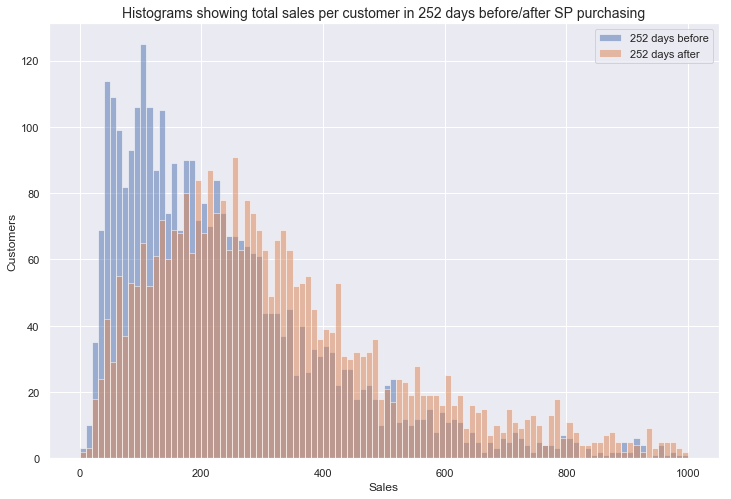

,252 days before,252 days after
count,3281.00,3281.00
mean,263.08,359.78
std,268.72,363.99
min,2.90,2.39
25%,108.93,177.88
50%,201.40,286.61
75%,332.68,445.26
max,6912.98,13342.51


In [54]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing total sales per customer in 252 days before/after SP purchasing', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('Sales')

sp_customers_252['SALES_252_BEF'].hist(bins=100, range=(0, 1000), alpha=0.5)
sp_customers_252['SALES_252_AFT'].hist(bins=100, range=(0, 1000), alpha=0.5)
plt.legend(['252 days before', '252 days after'])
concat_df = pd.concat([concat_df,
                    pd.DataFrame(sp_customers_252['SALES_252_BEF'].describe().round(2)),
                    pd.DataFrame(sp_customers_252['SALES_252_AFT'].describe().round(2)),
                        ], axis=1)
plt.show() 

concat_df.columns = ['252 days before', '252 days after']
display(concat_df)

#### AOV

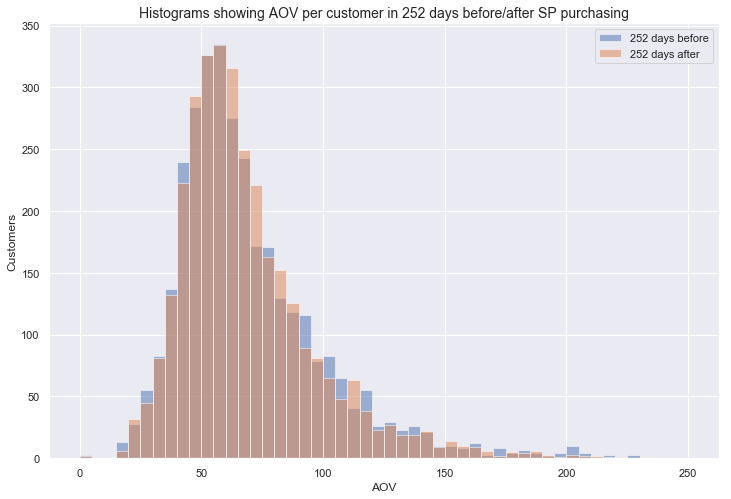

,252 days before,252 days after
count,3281.00,3281.00
mean,70.75,69.44
std,33.12,30.54
min,2.90,2.39
25%,49.81,50.12
50%,62.52,62.62
75%,83.88,80.90
max,356.79,355.46


In [55]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing AOV per customer in 252 days before/after SP purchasing', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('AOV')

sp_customers_252['AOV_252_BEF'].hist(bins=50, range=(0, 250), alpha=0.5)
sp_customers_252['AOV_252_AFT'].hist(bins=50, range=(0, 250), alpha=0.5)
plt.legend(['252 days before', '252 days after'])
concat_df = pd.concat([concat_df,
                    pd.DataFrame(sp_customers_252['AOV_252_BEF'].describe().round(2)),
                    pd.DataFrame(sp_customers_252['AOV_252_AFT'].describe().round(2)),
                        ], axis=1)
plt.show() 

concat_df.columns = ['252 days before', '252 days after']
display(concat_df)

#### Order Frequency

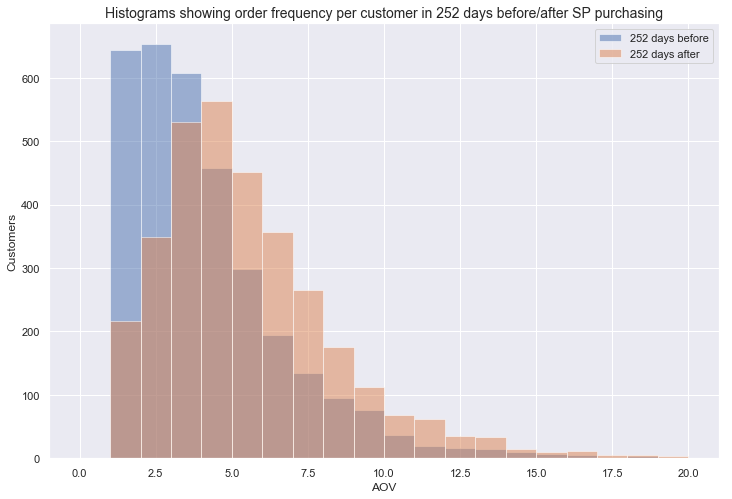

,252 days before,252 days after
count,3281.00,3281.00
mean,3.72,5.14
std,2.83,3.74
min,1.00,1.00
25%,2.00,3.00
50%,3.00,4.00
75%,5.00,6.00
max,36.00,114.00


In [56]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing order frequency per customer in 252 days before/after SP purchasing', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('AOV')

sp_customers_252['OF_252_BEF'].hist(bins=20, range=(0, 20), alpha=0.5)
sp_customers_252['OF_252_AFT'].hist(bins=20, range=(0, 20), alpha=0.5)
plt.legend(['252 days before', '252 days after'])
concat_df = pd.concat([concat_df,
                    pd.DataFrame(sp_customers_252['OF_252_BEF'].describe().round(2)),
                    pd.DataFrame(sp_customers_252['OF_252_AFT'].describe().round(2)),
                        ], axis=1)
plt.show() 

concat_df.columns = ['252 days before', '252 days after']
display(concat_df)

#### CM1% & CM2%

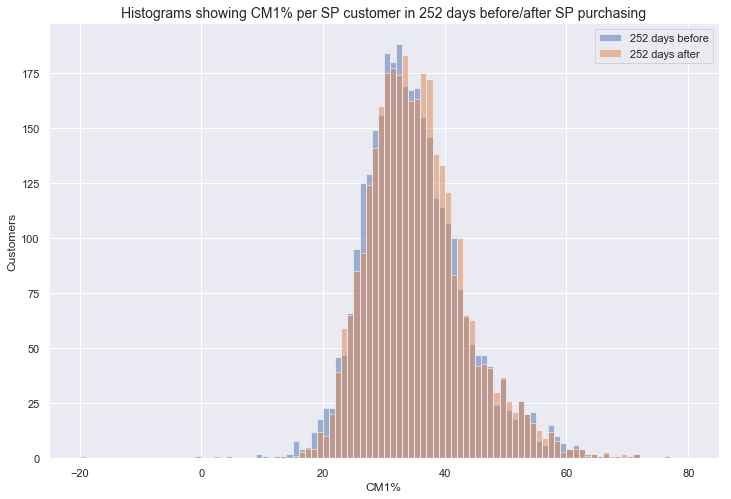

,252 days before,252 days after
count,3281.00,3281.00
mean,35.07,35.51
std,8.55,8.17
min,-0.53,-19.89
25%,29.39,29.98
50%,34.04,34.63
75%,39.61,39.89
max,100.00,100.00


In [57]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing CM1% per SP customer in 252 days before/after SP purchasing', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('CM1%')

sp_customers_252['CM1%_252_BEF'].hist(bins=100, range=(-20, 80), alpha=0.5)
sp_customers_252['CM1%_252_AFT'].hist(bins=100, range=(-20, 80), alpha=0.5)
plt.legend(['252 days before', '252 days after'])
concat_df = pd.concat([concat_df,
                    pd.DataFrame(sp_customers_252['CM1%_252_BEF'].describe().round(2)),
                    pd.DataFrame(sp_customers_252['CM1%_252_AFT'].describe().round(2)),
                        ], axis=1)
plt.show() 

concat_df.columns = ['252 days before', '252 days after']
display(concat_df)

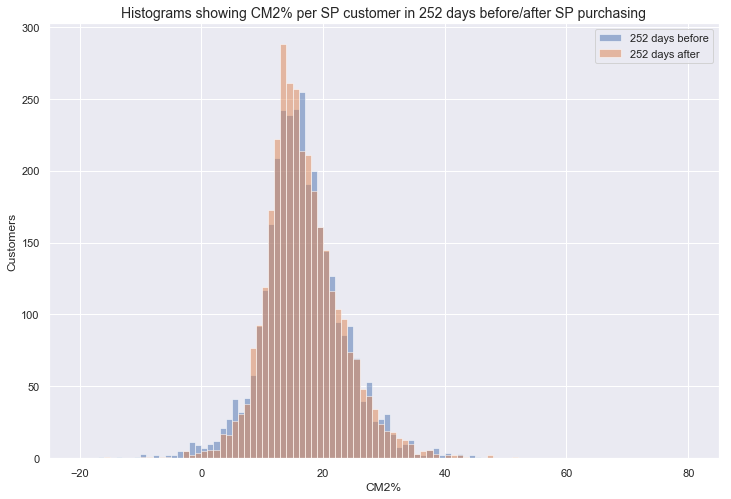

,252 days before,252 days after
count,3281.00,3281.00
mean,16.70,16.79
std,7.23,6.65
min,-21.45,-27.73
25%,12.79,12.85
50%,16.18,15.95
75%,20.34,20.25
max,100.00,100.00


In [58]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing CM2% per SP customer in 252 days before/after SP purchasing', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('CM2%')

sp_customers_252['CM2%_252_BEF'].hist(bins=100, range=(-20, 80), alpha=0.5)
sp_customers_252['CM2%_252_AFT'].hist(bins=100, range=(-20, 80), alpha=0.5)
plt.legend(['252 days before', '252 days after'])
concat_df = pd.concat([concat_df,
                    pd.DataFrame(sp_customers_252['CM2%_252_BEF'].describe().round(2)),
                    pd.DataFrame(sp_customers_252['CM2%_252_AFT'].describe().round(2)),
                        ], axis=1)
plt.show() 

concat_df.columns = ['252 days before', '252 days after']
display(concat_df)

#### Number of PG3s 

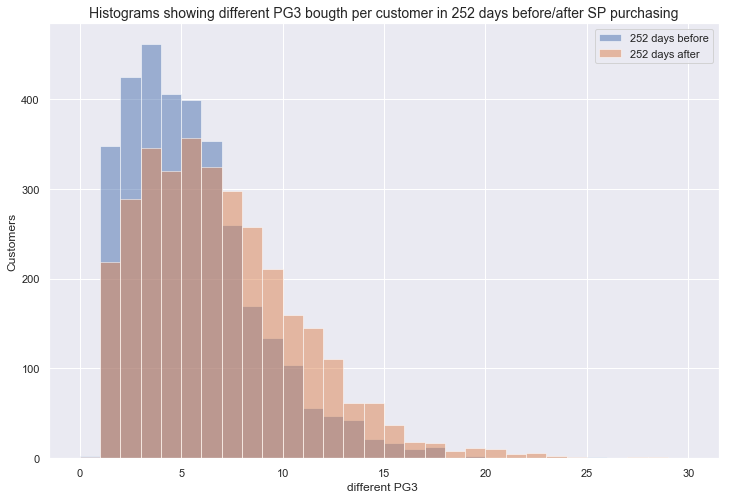

,252 days before,252 days after
count,3281.00,3281.00
mean,5.08,6.47
std,3.32,4.00
min,0.00,0.00
25%,3.00,3.00
50%,4.00,6.00
75%,7.00,9.00
max,25.00,28.00


In [59]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing different PG3 bougth per customer in 252 days before/after SP purchasing', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('different PG3 ')

sp_customers_252['DIFF_PG3_252_BEF'].hist(bins=30, range=(0, 30), alpha=0.5)
sp_customers_252['DIFF_PG3_252_AFT'].hist(bins=30, range=(0, 30), alpha=0.5)
plt.legend(['252 days before', '252 days after'])
concat_df = pd.concat([concat_df,
                    pd.DataFrame(sp_customers_252['DIFF_PG3_252_BEF'].describe().round(2)),
                    pd.DataFrame(sp_customers_252['DIFF_PG3_252_AFT'].describe().round(2)),
                        ], axis=1)
plt.show() 

concat_df.columns = ['252 days before', '252 days after']
display(concat_df)

#### PG3 shares and sales in each group

In [60]:
no_sp_flat_pg3_sales = [j for i in sp_customers_252['PG3_252_BEF_FLAT_SALES'].values for j in i]

In [61]:
no_sp_pg3_sales = sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in no_sp_flat_pg3_sales if pg3==pg_3_
                                                        ]), 3)) 
                                for pg3 in set([pg_3 for pg_3, sales in no_sp_flat_pg3_sales])], key= lambda x: x[1], reverse=True)

In [62]:
no_sp_pg3_dict_sales_no_disc = {i[0]: i[1] for i in no_sp_pg3_sales if i[0] != 0}

In [63]:
no_sp_pg3_dict_sales_share = {a: np.round(b/sum(no_sp_pg3_dict_sales_no_disc.values())*100, 3) 
                                                     for a, b in list(zip(no_sp_pg3_dict_sales_no_disc.keys(),
                                                                          no_sp_pg3_dict_sales_no_disc.values()))}

In [64]:
filter_no_sp_pg3_dict_sales_share = {x: y for x, y in list(zip(no_sp_pg3_dict_sales_share.keys(),
                                                                no_sp_pg3_dict_sales_share.values()))
                                            if y >= 1}

In [65]:
sum(filter_no_sp_pg3_dict_sales_share.values())

91.30400000000002

In [66]:
sp_flat_pg3_sales = [j for i in sp_customers_252['PG3_252_AFT_FLAT_SALES'].values for j in i]

In [67]:
sp_pg3_sales = sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in sp_flat_pg3_sales if pg3==pg_3_
                                                        ]), 3)) 
                                for pg3 in set([pg_3 for pg_3, sales in sp_flat_pg3_sales])], key= lambda x: x[1], reverse=True)

In [68]:
sp_pg3_dict_sales_no_disc = {i[0]: i[1] for i in sp_pg3_sales if i[0] != 0}

In [69]:
sp_pg3_dict_sales_share = {a: np.round(b/sum(sp_pg3_dict_sales_no_disc.values())*100, 3) 
                                                     for a, b in list(zip(sp_pg3_dict_sales_no_disc.keys(),
                                                                          sp_pg3_dict_sales_no_disc.values()))}

In [70]:
filter_sp_pg3_dict_sales_share = {x: y for x, y in list(zip(sp_pg3_dict_sales_share.keys(),
                                                                    sp_pg3_dict_sales_share.values()))
                                            if y >= 1}

In [71]:
sum(filter_sp_pg3_dict_sales_share.values())

89.56500000000003

In [72]:
no_sp_cus_pg3_share_df = pd.DataFrame.from_dict(filter_no_sp_pg3_dict_sales_share, orient='index')
sp_cus_pg3_share_df = pd.DataFrame.from_dict(filter_sp_pg3_dict_sales_share, orient='index')

In [73]:
pg3_share_comparison = pd.concat([no_sp_cus_pg3_share_df,sp_cus_pg3_share_df], axis=1).fillna(0)
pg3_share_comparison.columns = ['NO_SP_ORD', 'SP_ORD']
pg3_share_comparison['PG3'] = pg3_share_comparison.index.values
#pg3_share_comparison['PG3'] = pg3_share_comparison['PG3'].astype(str)
pg3_share_comparison = pg3_share_comparison[['PG3', 'NO_SP_ORD', 'SP_ORD']]

In [74]:
pg3_l = list(pg3_share_comparison['PG3'].values)

In [75]:
pg3_list = repr(pg3_l).replace('[','(').replace(']',')')

In [76]:
query = """select pg_id, pg_shortlink from ZOOMAN.PRODUCT_GROUPS
where pg_id in %s""" % pg3_list

In [77]:
conn = cx_Oracle.connect('zooor', 'zoo12or', 'zoorep', threaded=True, encoding = "UTF-8", nencoding = "UTF-8")
pg3 = pd.read_sql(query, con = conn)
conn.close()

In [78]:
pg3

,PG_ID,PG_SHORTLINK
0,9,hundebett
1,18,hundesnacks
2,20,hundespielzeug
3,23,kratzbaum_katzenbaum
4,29,katzentoilette
5,33,fressnapf
6,34,katzensnacks
7,36,katzenspielzeug
8,251,hundefutter_trockenfutter
9,252,katzenfutter_trockenfutter


In [79]:
pg3_dict = {x: y for x, y in list(zip(pg3['PG_ID'].values, pg3['PG_SHORTLINK'].values))}

In [80]:
pg3_share_comparison['PG3_NAME'] = [pg3_dict[i] for i in pg3_share_comparison['PG3'].values]

In [81]:
pg3_share_comparison

,PG3,NO_SP_ORD,SP_ORD,PG3_NAME
9,9,1.522,1.778,hundebett
18,18,3.938,3.473,hundesnacks
20,20,1.150,1.266,hundespielzeug
23,23,1.888,3.441,kratzbaum_katzenbaum
29,29,2.121,2.697,katzentoilette
33,33,1.281,1.653,fressnapf
34,34,1.579,1.324,katzensnacks
36,36,1.295,1.527,katzenspielzeug
251,251,34.223,32.355,hundefutter_trockenfutter
252,252,17.696,17.174,katzenfutter_trockenfutter


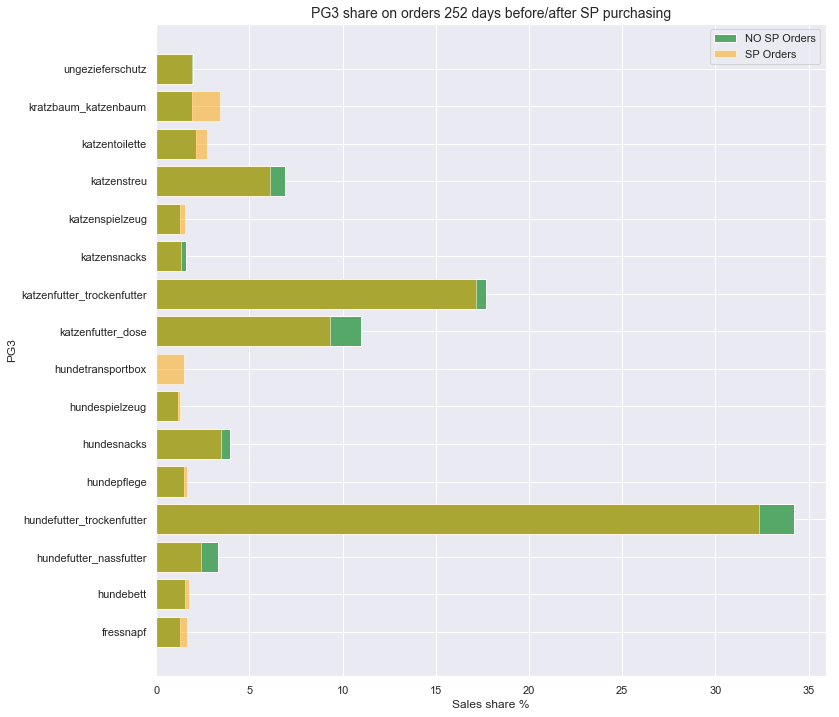

In [82]:
plt.figure(figsize=(12, 12))
x = pg3_share_comparison['PG3_NAME'].values
y = pg3_share_comparison['NO_SP_ORD'].values
z = pg3_share_comparison['SP_ORD'].values
plt.barh(x, y, color='g')
plt.barh(x, z, color='orange', alpha=0.5)
plt.title('PG3 share on orders 252 days before/after SP purchasing', fontsize=14)
plt.ylabel('PG3')
plt.xlabel('Sales share %')
plt.legend(['NO SP Orders', 'SP Orders'])
plt.show()

In [83]:
no_sp_cus_pg3_sales_df = pd.DataFrame.from_dict(no_sp_pg3_dict_sales_no_disc, orient='index')
sp_cus_pg3_sales_df = pd.DataFrame.from_dict(sp_pg3_dict_sales_no_disc, orient='index')

In [84]:
pg3_sales_comparison = pd.concat([no_sp_cus_pg3_sales_df, sp_cus_pg3_sales_df], axis=1).fillna(0)
pg3_sales_comparison.columns = ['NO_SP_ORD', 'SP_ORD']
pg3_sales_comparison['PG3'] = pg3_sales_comparison.index.values
#pg3_sales_comparison['PG3'] = pg3_sales_comparison['PG3'].astype(str)

In [85]:
pg3_lis = list(pg3_sales_comparison['PG3'].values)

In [86]:
pg3_lista = repr(pg3_lis).replace('[','(').replace(']',')')

In [87]:
query = """select pg_id, pg_shortlink from ZOOMAN.PRODUCT_GROUPS
where pg_id in %s""" % pg3_lista

In [88]:
conn = cx_Oracle.connect('zooor', 'zoo12or', 'zoorep', threaded=True, encoding = "UTF-8", nencoding = "UTF-8")
pg3 = pd.read_sql(query, con = conn)
conn.close()

In [89]:
pg3_dict = {x: y for x, y in list(zip(pg3['PG_ID'].values, pg3['PG_SHORTLINK'].values))}

In [90]:
pg3_sales_comparison['PG3_NAME'] = [pg3_dict[i] for i in pg3_sales_comparison['PG3'].values]

In [91]:
pg3_sales_comparison = pg3_sales_comparison[['PG3', 'PG3_NAME', 'NO_SP_ORD', 'SP_ORD']]
pg3_sales_comparison = pg3_sales_comparison[(pg3_sales_comparison['NO_SP_ORD'] >= 1000) | (pg3_sales_comparison['SP_ORD'] >= 1000)]

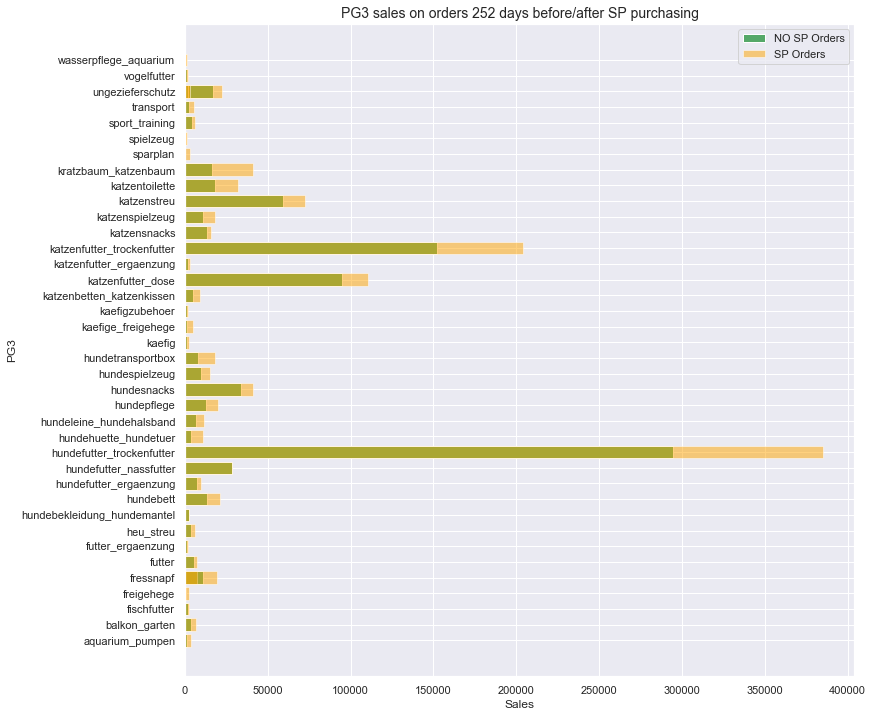

In [92]:
plt.figure(figsize=(12, 12))
x = pg3_sales_comparison['PG3_NAME'].values
y = pg3_sales_comparison['NO_SP_ORD'].values
z = pg3_sales_comparison['SP_ORD'].values
plt.barh(x, y, color='g')
plt.barh(x, z, color='orange', alpha=0.5)
plt.title('PG3 sales on orders 252 days before/after SP purchasing', fontsize=14)
plt.ylabel('PG3')
plt.xlabel('Sales')
plt.legend(['NO SP Orders', 'SP Orders'])
plt.show()

In [93]:
pg3_sales_comparison

,PG3,PG3_NAME,NO_SP_ORD,SP_ORD
9,9,hundebett,13107.94,21152.39
15,15,hundeleine_hundehalsband,6629.55,11740.76
16,16,fressnapf,4149.23,7316.03
18,18,hundesnacks,33918.27,41303.06
20,20,hundespielzeug,9906.26,15056.46
23,23,kratzbaum_katzenbaum,16259.94,40926.45
29,29,katzentoilette,18269.32,32075.61
33,33,fressnapf,11037.56,19666.99
34,34,katzensnacks,13598.09,15753.13
36,36,katzenspielzeug,11156.17,18166.09


#### Average Sales Share of Royal Canin products – 252 days orders before/after SP purchasing

In [94]:
sp_customers_252['BRAND_SALES_252_BEF'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_252['BRAND_AGGSALES'],
                                                                                    sp_customers_252['MASK_252_BEF']))]

In [95]:
sp_customers_252['BRAND_SALES_252_AFT'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_252['BRAND_AGGSALES'],
                                                                                    sp_customers_252['MASK_252_AFT']))]

In [96]:
sp_customers_252['BRAND_FLAT_SALES_252_BEF'] = [[k for j in i for k in j] 
                                                for i in sp_customers_252['BRAND_SALES_252_BEF'].values]

In [97]:
sp_customers_252['BRAND_FLAT_SALES_252_AFT'] = [[k for j in i for k in j] 
                                                for i in sp_customers_252['BRAND_SALES_252_AFT'].values]

In [98]:
no_sp_flat_brand_sales = [j for i in sp_customers_252['BRAND_FLAT_SALES_252_BEF'].values for j in i]

In [99]:
sp_flat_brand_sales = [j for i in sp_customers_252['BRAND_FLAT_SALES_252_AFT'].values for j in i]

In [100]:
no_sp_brand_sales = sorted([(brand_, np.round(sum([sales_ for brand__, sales_ in no_sp_flat_brand_sales if brand_== brand__
                                                        ]), 3)) 
                                for brand_ in set([brand for brand, sales in no_sp_flat_brand_sales])], key= lambda x: x[1], reverse=True) 

In [101]:
sp_brand_sales = sorted([(brand_, np.round(sum([sales_ for brand__, sales_ in sp_flat_brand_sales if brand_== brand__
                                                        ]), 3)) 
                                for brand_ in set([brand for brand, sales in sp_flat_brand_sales])], key= lambda x: x[1], reverse=True) 

In [102]:
no_sp_dict_sales_no_disc = {i[0]: i[1] for i in no_sp_brand_sales if str(i[0]) != 'nan'}

In [103]:
sp_dict_sales_no_disc = {i[0]: i[1] for i in sp_brand_sales if str(i[0]) != 'nan'}

In [104]:
no_sp_dict_sales_share = {a: np.round(b/sum(no_sp_dict_sales_no_disc.values())*100, 3)
                         for a, b in list(zip(no_sp_dict_sales_no_disc.keys(),
                                             no_sp_dict_sales_no_disc.values()))}

In [105]:
sp_dict_sales_share = {a: np.round(b/sum(sp_dict_sales_no_disc.values())*100, 3)
                         for a, b in list(zip(sp_dict_sales_no_disc.keys(),
                                             sp_dict_sales_no_disc.values()))}

In [106]:
sum(no_sp_dict_sales_share.values()), sum(sp_dict_sales_share.values())

(99.99300000000022, 100.00000000000001)

In [107]:
brands = pd.read_csv('pg4_brands.dsv', sep=';', low_memory=False)

In [108]:
brands['BRAND'] = [i.split(' - ')[1] if len(i.split('-')) > 1 else 'unknown' for i in brands['PPR_V_LEVEL4_DESC'].values]

In [109]:
brands.head()

,PPR_N_LEVEL4_ID,PPR_V_LEVEL4_DESC,BRAND
0,20745,20745 - Hundesofa,Hundesofa
1,2,2 - Hund,Hund
2,1422,1422 - Spielzeug,Spielzeug
3,75,75 - Hundekissen,Hundekissen
4,2157,2157 - Alle Katzenklappen,Alle Katzenklappen


In [110]:
RC_brands = brands[brands['BRAND'].str.contains('Royal Canin')][['PPR_N_LEVEL4_ID', 'BRAND']]
RC_brands

,PPR_N_LEVEL4_ID,BRAND
185,126742,Royal Canin Dog
257,17798,Royal Canin Breed (Rasse)
274,1308,Royal Canin Club / Selection
296,9702,Royal Canin Pure Feline
444,81396,Royal Canin Veterinary Diet
449,82696,Royal Canin Veterinary Diet
477,209912,Royal Canin Vet Care Nutrition
710,127037,Royal Canin Universal
790,682,Royal Canin Size
952,94525,Royal Canin


In [111]:
no_sp_rc_share_dict = {a: b for a, b in list(zip(no_sp_dict_sales_share.keys(), 
                                                 no_sp_dict_sales_share.values()))
                      if a in RC_brands['BRAND'].values}

In [112]:
no_sp_rc_share_dict

{'Royal Canin': 6.089,
 'Royal Canin Breed (Rasse)': 2.609,
 'Royal Canin Club / Selection': 0.194,
 'Royal Canin Dog': 0.0,
 'Royal Canin Pure Feline': 0.006,
 'Royal Canin Rasse (Breed)': 0.576,
 'Royal Canin Size': 4.075,
 'Royal Canin Vet Care Nutrition': 0.849,
 'Royal Canin Veterinary Diet': 3.732}

In [113]:
sp_rc_share_dict = {a: b for a, b in list(zip(sp_dict_sales_share.keys(), 
                                            sp_dict_sales_share.values()))
                      if a in RC_brands['BRAND'].values}

In [114]:
sp_rc_share_dict

{'Royal Canin': 5.931,
 'Royal Canin Breed (Rasse)': 2.576,
 'Royal Canin Cat': 0.001,
 'Royal Canin Club / Selection': 0.256,
 'Royal Canin Dog': 0.0,
 'Royal Canin Pure Feline': 0.019,
 'Royal Canin Rasse (Breed)': 0.593,
 'Royal Canin Size': 4.301,
 'Royal Canin Vet Care Nutrition': 0.797,
 'Royal Canin Veterinary Diet': 3.837}

In [115]:
no_sp_rc_share_df = pd.DataFrame.from_dict(no_sp_rc_share_dict, orient='index')
sp_rc_share_df = pd.DataFrame.from_dict(sp_rc_share_dict, orient='index')

In [116]:
rc_comparison = pd.concat([no_sp_rc_share_df, sp_rc_share_df], axis=1).fillna(0)
rc_comparison.columns = ['NO_SP_ORD', 'SP_ORD']
rc_comparison['BRAND'] = rc_comparison.index.values
rc_comparison = rc_comparison[['BRAND', 'NO_SP_ORD', 'SP_ORD']]
rc_comparison

,BRAND,NO_SP_ORD,SP_ORD
Royal Canin,Royal Canin,6.089,5.931
Royal Canin Breed (Rasse),Royal Canin Breed (Rasse),2.609,2.576
Royal Canin Cat,Royal Canin Cat,0.000,0.001
Royal Canin Club / Selection,Royal Canin Club / Selection,0.194,0.256
Royal Canin Dog,Royal Canin Dog,0.000,0.000
Royal Canin Pure Feline,Royal Canin Pure Feline,0.006,0.019
Royal Canin Rasse (Breed),Royal Canin Rasse (Breed),0.576,0.593
Royal Canin Size,Royal Canin Size,4.075,4.301
Royal Canin Vet Care Nutrition,Royal Canin Vet Care Nutrition,0.849,0.797
Royal Canin Veterinary Diet,Royal Canin Veterinary Diet,3.732,3.837


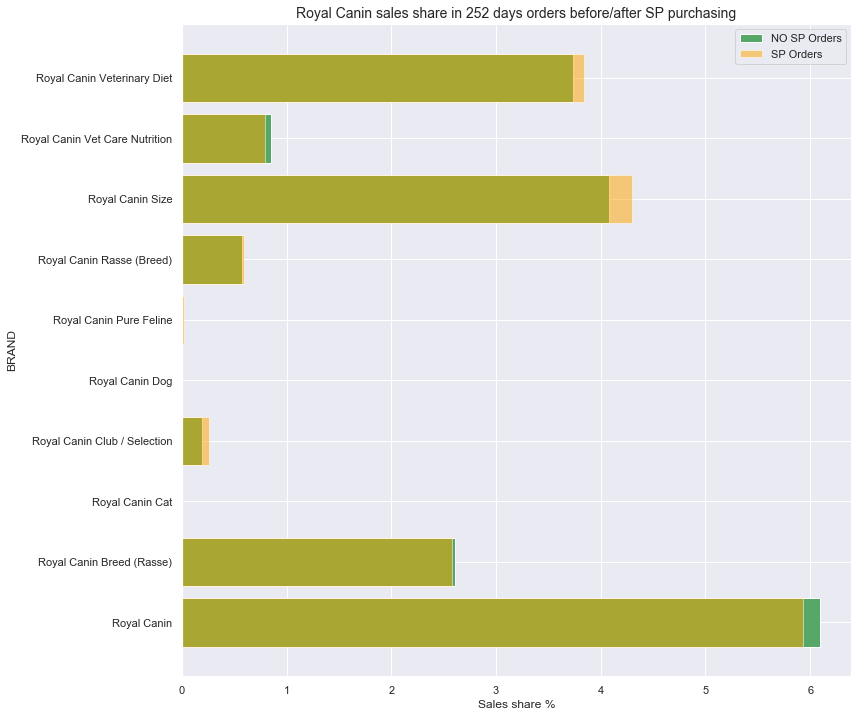

In [117]:
plt.figure(figsize=(12, 12))
x = rc_comparison['BRAND'].values
y = rc_comparison['NO_SP_ORD'].values
z = rc_comparison['SP_ORD'].values
plt.barh(x, y, color='g')
plt.barh(x, z, color='orange', alpha=0.5)
plt.title('Royal Canin sales share in 252 days orders before/after SP purchasing', fontsize=14)
plt.ylabel('BRAND')
plt.xlabel('Sales share %')
plt.legend(['NO SP Orders', 'SP Orders'])
plt.show()

#### Royal Canin sales -  252 days orders before/after SP purchasing

In [118]:
no_sp_rc_sales_dict = {a: b for a, b in list(zip(no_sp_dict_sales_no_disc.keys(), 
                                            no_sp_dict_sales_no_disc.values()))
                      if a in RC_brands['BRAND'].values}

In [119]:
no_sp_rc_sales_dict

{'Royal Canin': 52443.83,
 'Royal Canin Breed (Rasse)': 22474.22,
 'Royal Canin Club / Selection': 1674.72,
 'Royal Canin Dog': 0.59,
 'Royal Canin Pure Feline': 55.46,
 'Royal Canin Rasse (Breed)': 4961.8,
 'Royal Canin Size': 35099.26,
 'Royal Canin Vet Care Nutrition': 7310.67,
 'Royal Canin Veterinary Diet': 32140.47}

In [120]:
sp_rc_sales_dict = {a: b for a, b in list(zip(sp_dict_sales_no_disc.keys(), 
                                            sp_dict_sales_no_disc.values()))
                      if a in RC_brands['BRAND'].values}

In [121]:
sp_rc_sales_dict

{'Royal Canin': 70541.75,
 'Royal Canin Breed (Rasse)': 30637.95,
 'Royal Canin Cat': 6.1,
 'Royal Canin Club / Selection': 3041.87,
 'Royal Canin Dog': 0.59,
 'Royal Canin Pure Feline': 222.34,
 'Royal Canin Rasse (Breed)': 7050.82,
 'Royal Canin Size': 51152.55,
 'Royal Canin Vet Care Nutrition': 9484.29,
 'Royal Canin Veterinary Diet': 45638.79}

In [122]:
no_sp_rc_sales_df = pd.DataFrame.from_dict(no_sp_rc_sales_dict, orient='index')
sp_rc_sales_df = pd.DataFrame.from_dict(sp_rc_sales_dict, orient='index')

In [123]:
rc_sales_comparison = pd.concat([no_sp_rc_sales_df, sp_rc_sales_df], axis=1).fillna(0)
rc_sales_comparison.columns = ['NO_SP_ORD', 'SP_ORD']
rc_sales_comparison['BRAND'] = rc_sales_comparison.index.values
rc_sales_comparison = rc_sales_comparison[['BRAND', 'NO_SP_ORD', 'SP_ORD']]
rc_sales_comparison

,BRAND,NO_SP_ORD,SP_ORD
Royal Canin,Royal Canin,52443.83,70541.75
Royal Canin Breed (Rasse),Royal Canin Breed (Rasse),22474.22,30637.95
Royal Canin Cat,Royal Canin Cat,0.00,6.10
Royal Canin Club / Selection,Royal Canin Club / Selection,1674.72,3041.87
Royal Canin Dog,Royal Canin Dog,0.59,0.59
Royal Canin Pure Feline,Royal Canin Pure Feline,55.46,222.34
Royal Canin Rasse (Breed),Royal Canin Rasse (Breed),4961.80,7050.82
Royal Canin Size,Royal Canin Size,35099.26,51152.55
Royal Canin Vet Care Nutrition,Royal Canin Vet Care Nutrition,7310.67,9484.29
Royal Canin Veterinary Diet,Royal Canin Veterinary Diet,32140.47,45638.79


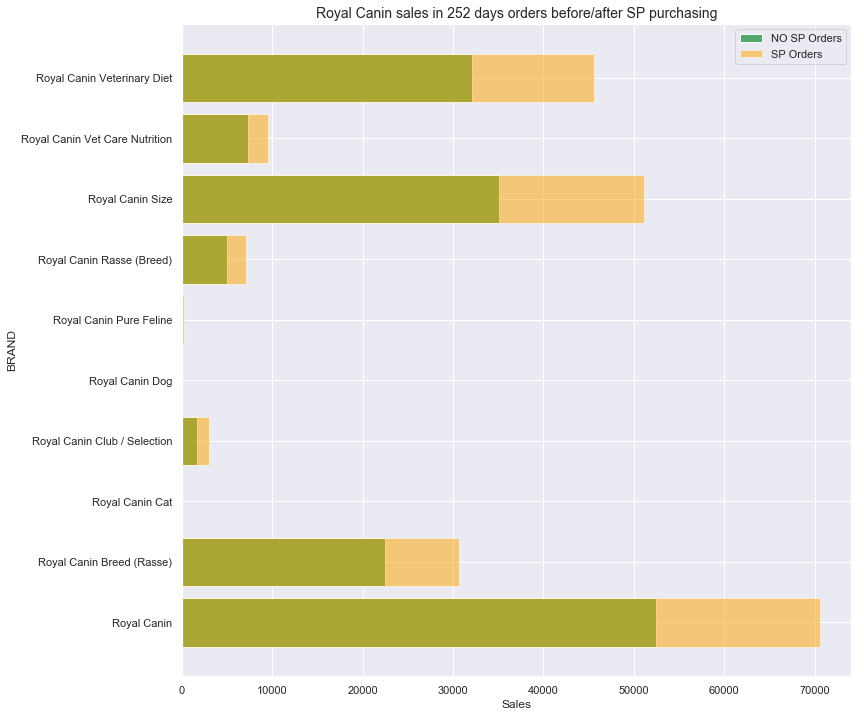

In [124]:
plt.figure(figsize=(12, 12))
x = rc_sales_comparison['BRAND'].values
y = rc_sales_comparison['NO_SP_ORD'].values
z = rc_sales_comparison['SP_ORD'].values
plt.barh(x, y, color='g')
plt.barh(x, z, color='orange', alpha=0.5)
plt.title('Royal Canin sales in 252 days orders before/after SP purchasing', fontsize=14)
plt.ylabel('BRAND')
plt.xlabel('Sales')
plt.legend(['NO SP Orders', 'SP Orders'])
plt.show()

#### Average Sales Share of Hill's products – 252 days orders before/after SP purchasing

In [125]:
Hills_brands = brands[brands['BRAND'].str.contains("Hill's")][['PPR_N_LEVEL4_ID', 'BRAND']]
Hills_brands

,PPR_N_LEVEL4_ID,BRAND
13,719,Hill's Science Plan
188,84729,Hill's Prescription Diet
261,1816,Hill's Puppy & Senior
270,2058,Hill's Natures Best
295,720,Hill's Science Plan
472,151599,Hill's Prescription Diet
735,175240,Hill's Ideal Balance
736,177843,Hill's Ideal Balance
1150,31962,Hill's Prescription Diet
1381,31963,Hill's Prescription Diet


In [126]:
no_sp_hills_share_dict = {a: b for a, b in list(zip(no_sp_dict_sales_share.keys(), 
                                                 no_sp_dict_sales_share.values()))
                      if a in Hills_brands['BRAND'].values}

In [127]:
no_sp_hills_share_dict

{"Hill's Ideal Balance": 0.13,
 "Hill's Natures Best": 0.085,
 "Hill's Prescription Diet": 8.465,
 "Hill's Science Plan": 2.74,
 "Nature's Best von Hill's": 0.057}

In [128]:
sp_hills_share_dict = {a: b for a, b in list(zip(sp_dict_sales_share.keys(), 
                                                 sp_dict_sales_share.values()))
                      if a in Hills_brands['BRAND'].values}

In [129]:
sp_hills_share_dict

{"Hill's Ideal Balance": 0.093,
 "Hill's Natures Best": 0.103,
 "Hill's Prescription Diet": 7.749,
 "Hill's Science Plan": 2.792,
 "Nature's Best von Hill's": 0.058}

In [130]:
no_sp_hills_share_df = pd.DataFrame.from_dict(no_sp_hills_share_dict, orient='index')
sp_hills_share_df = pd.DataFrame.from_dict(sp_hills_share_dict, orient='index')

In [131]:
hills_comparison = pd.concat([no_sp_hills_share_df, sp_hills_share_df], axis=1).fillna(0)
hills_comparison.columns = ['NO_SP_ORD', 'SP_ORD']
hills_comparison['BRAND'] = hills_comparison.index.values
hills_comparison = hills_comparison[['BRAND', 'NO_SP_ORD', 'SP_ORD']]
hills_comparison

,BRAND,NO_SP_ORD,SP_ORD
Hill's Ideal Balance,Hill's Ideal Balance,0.130,0.093
Hill's Natures Best,Hill's Natures Best,0.085,0.103
Hill's Prescription Diet,Hill's Prescription Diet,8.465,7.749
Hill's Science Plan,Hill's Science Plan,2.740,2.792
Nature's Best von Hill's,Nature's Best von Hill's,0.057,0.058


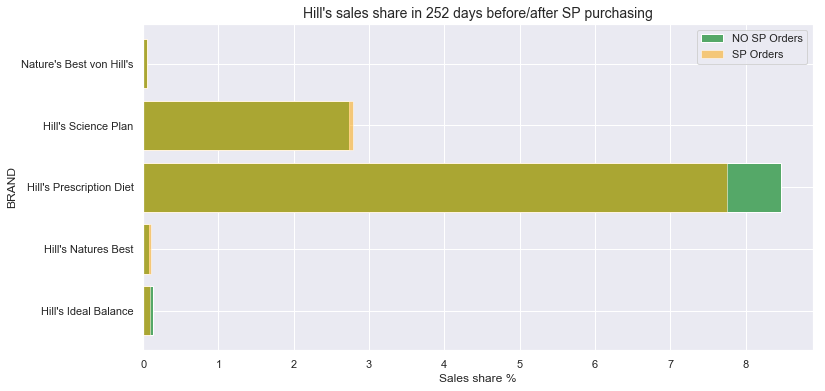

In [132]:
plt.figure(figsize=(12, 6))
x = hills_comparison['BRAND'].values
y = hills_comparison['NO_SP_ORD'].values
z = hills_comparison['SP_ORD'].values
plt.barh(x, y, color='g')
plt.barh(x, z, color='orange', alpha=0.5)
plt.title("Hill's sales share in 252 days before/after SP purchasing", fontsize=14)
plt.ylabel('BRAND')
plt.xlabel('Sales share %')
plt.legend(['NO SP Orders', 'SP Orders'])
plt.show()

#### Hill's sales -  252 days orders before/after SP purchasing

In [133]:
no_sp_hills_sales_dict = {a: b for a, b in list(zip(no_sp_dict_sales_no_disc.keys(), 
                                            no_sp_dict_sales_no_disc.values()))
                      if a in Hills_brands['BRAND'].values}

In [134]:
no_sp_hills_sales_dict

{"Hill's Ideal Balance": 1116.72,
 "Hill's Natures Best": 732.87,
 "Hill's Prescription Diet": 72908.34,
 "Hill's Science Plan": 23601.13,
 "Nature's Best von Hill's": 494.8}

In [135]:
sp_hills_sales_dict = {a: b for a, b in list(zip(sp_dict_sales_no_disc.keys(), 
                                            sp_dict_sales_no_disc.values()))
                      if a in Hills_brands['BRAND'].values}

In [136]:
sp_hills_sales_dict

{"Hill's Ideal Balance": 1100.98,
 "Hill's Natures Best": 1229.47,
 "Hill's Prescription Diet": 92164.42,
 "Hill's Science Plan": 33206.77,
 "Nature's Best von Hill's": 686.76}

In [137]:
no_sp_hills_sales_df = pd.DataFrame.from_dict(no_sp_hills_sales_dict, orient='index')
sp_hills_sales_df = pd.DataFrame.from_dict(sp_hills_sales_dict, orient='index')

In [138]:
hills_sales_comparison = pd.concat([no_sp_hills_sales_df, sp_hills_sales_df], axis=1).fillna(0)
hills_sales_comparison.columns = ['NO_SP_ORD', 'SP_ORD']
hills_sales_comparison['BRAND'] = hills_sales_comparison.index.values
hills_sales_comparison = hills_sales_comparison[['BRAND', 'NO_SP_ORD', 'SP_ORD']]
hills_sales_comparison

,BRAND,NO_SP_ORD,SP_ORD
Hill's Ideal Balance,Hill's Ideal Balance,1116.72,1100.98
Hill's Natures Best,Hill's Natures Best,732.87,1229.47
Hill's Prescription Diet,Hill's Prescription Diet,72908.34,92164.42
Hill's Science Plan,Hill's Science Plan,23601.13,33206.77
Nature's Best von Hill's,Nature's Best von Hill's,494.80,686.76


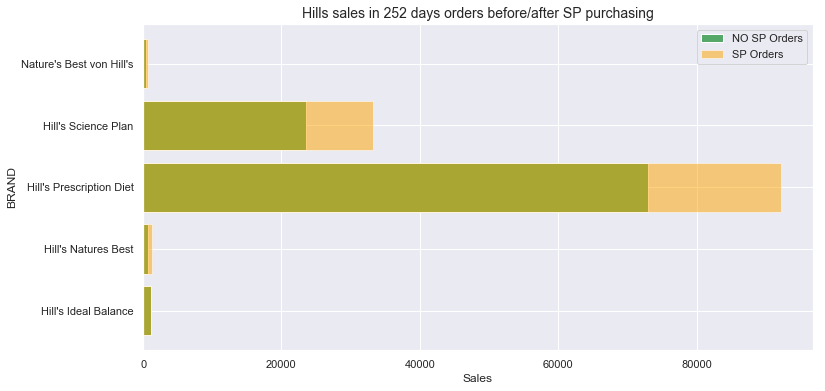

In [139]:
plt.figure(figsize=(12, 6))
x = hills_sales_comparison['BRAND'].values
y = hills_sales_comparison['NO_SP_ORD'].values
z = hills_sales_comparison['SP_ORD'].values
plt.barh(x, y, color='g')
plt.barh(x, z, color='orange', alpha=0.5)
plt.title('Hills sales in 252 days orders before/after SP purchasing', fontsize=14)
plt.ylabel('BRAND')
plt.xlabel('Sales')
plt.legend(['NO SP Orders', 'SP Orders'])
plt.show()

##### Timedeltas between orders before/after SP purchasing (every data available for the customer, not only 252 days)

In [140]:
sp_customers_252.columns

Index(['CUS_N_KEY_CUSTOMER', 'SCM_N_ORDER_NR_len', 'TDT_T_KEY_ORDER_DATE_list',
       'SCM_SALES_BMF_sum', 'SCM_SALES_BMF_list', 'SCM_D_FINANCE_CM1_sum',
       'SCM_D_FINANCE_CM1_list', 'SCM_D_FINANCE_CM2_sum',
       'SCM_D_FINANCE_CM2_list', 'SCM_D_ORIG_FINANCE_ORDER_NET_sum',
       'SCM_D_ORIG_FINANCE_ORDER_NET_list', 'OSP_KO_COUNT_NET_list',
       'SCM_MASTER_AP_ID_list', 'CZP_ZTQ_ID', 'CZP_START_DATE',
       'CZP_EXPIRY_DATE', 'PG3_AGGSALES', 'PG4_AGGSALES', 'BRAND_AGGSALES',
       'SP_PURCHASE', 'SP_DISC', 'D28', 'D56', 'D84', 'D168', 'D252', 'D336',
       'O_TIMEDELTAS', 'FLAT_PG3_SALES', 'FLAT_PG4_SALES', 'FLAT_BRAND_SALES',
       'TOTAL_PG3_SALES', 'TOTAL_PG4_SALES', 'TOTAL_BRAND_SALES', 'SP_PY_POS',
       'DAYS_UNTIL_1st_SP', 'SP_ORDERS', 'NO_SP_ORDERS', 'DAYS_IN_DF',
       'DAYS_AFTER_1st_SP', 'SP_CUS', 'MASK_252_BEF', 'MASK_252_AFT',
       'ONE_ORDER_BEFORE', 'SALES_252_BEF', 'SALES_252_AFT', 'AOV_252_BEF',
       'AOV_252_AFT', 'OF_252_BEF', 'OF_252_AFT', 'CM1_2

In [141]:
sp_customers_252['TD_BEFORE_SP'] = [x[:(y-1)] for x, y in list(zip(sp_customers_252['O_TIMEDELTAS'],
                                               sp_customers_252['SP_PY_POS']))]

In [142]:
sp_customers_252['TD_AFTER_SP'] = [x[(y-1):] for x, y in list(zip(sp_customers_252['O_TIMEDELTAS'],
                                               sp_customers_252['SP_PY_POS']))]

In [143]:
td_before_sp = [j for i in sp_customers_252['TD_BEFORE_SP'].values for j in i]

In [144]:
td_after_sp = [j for i in sp_customers_252['TD_AFTER_SP'].values for j in i]

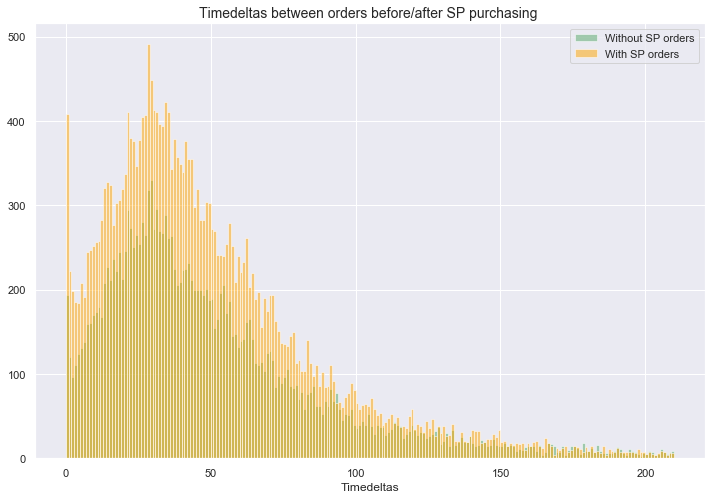

,Without SP orders,With SP orders
25%,24.00,24.00
50%,42.00,41.00
75%,71.00,67.00
count,18787.00,27268.00
max,748.00,560.00
mean,59.54,51.93
min,0.00,0.00
std,63.37,44.85


In [145]:
concat_df = pd.DataFrame()

plt.figure(figsize=(12, 8))
plt.hist(td_before_sp, bins=210, range=(0, 210), color='g', alpha=0.5)
plt.hist(td_after_sp, bins=210, range=(0, 210), color='orange', alpha=0.5)
plt.title("Timedeltas between orders before/after SP purchasing ", fontsize=14)
plt.xlabel('Timedeltas')
plt.legend(['Without SP orders', 'With SP orders'])
plt.show()

before_sp_td = pd.DataFrame(np.array(td_before_sp).reshape(len(td_before_sp), 1), columns= ['TD_BEFORE_SP'])
after_sp_td = pd.DataFrame(np.array(td_after_sp).reshape(len(td_after_sp), 1), columns= ['TD_AFTER_SP'])

concat_df = pd.concat([concat_df,
                    before_sp_td['TD_BEFORE_SP'].describe().round(2),
                    after_sp_td['TD_AFTER_SP'].describe().round(2),
                      ], axis=1)

concat_df.columns = ['Without SP orders', 'With SP orders']
display(concat_df)